In [1]:
%load_ext autoreload
%autoreload 2

In [56]:
import os
from datetime import datetime
import matplotlib.pyplot as plt

import torch
from torchvision import transforms
from torch.utils.data import Subset
from torchvision.datasets import ImageFolder
from torch.utils.tensorboard import SummaryWriter

from utils.save_load import save_model, load_model

In [3]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(torch.cuda.is_available())

True


In [4]:
BASE_LOG_DIR = os.path.join(os.getcwd(), "tboard_logs")

os.makedirs(BASE_LOG_DIR, exist_ok=True)

## Task 1

 - Implement the (adapted) TriNet Siamese model and SimCLR:
    - ResNet convolutional backbone (until AvgPool) 
    - Fully connected frontend to obtain desired embedding
    - Normalization layer
 - Use *Labeled Faces in the Wild* (LFW) dataset (https://www.kaggle.com/datasets/jessicali9530/lfw-dataset)
    - Over 13000 images
    - Train and test set
 - Train and Evaluate TriNet and SimCLR models
    - Try to find adequate temperature and margin values 
    - How do the models compare?
 - Evaluate and compare the model performance (need not be thorough)
 - Visualize embeddings (not necessary for all classes, e.g. pick the 10 classes with the most images)

### Dataset

In [6]:
# RUN once to save locally
# import kagglehub

# path = kagglehub.dataset_download("jessicali9530/lfw-dataset")

# SAVE_PATH = "./data"
# os.makedirs(SAVE_PATH, exist_ok=True)
# shutil.move(path, SAVE_PATH)

/home/user/imashevv1/CudaLabSS25/venv/lib/python3.8/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 112M/112M [00:03<00:00, 34.4MB/s]

Extracting model files...


'./data/4'

In [5]:
IMG_SIZE = 64
DATASET_PATH = "./data/4/lfw-deepfunneled/lfw-deepfunneled"

transform = transforms.Compose([
    transforms.Resize((IMG_SIZE, IMG_SIZE)),
    transforms.ToTensor()
])

lfw_dataset = ImageFolder(DATASET_PATH, transform=transform)

Creating test/train subsets:

In [6]:
from sklearn.model_selection import train_test_split

TEST_SPLIT = .2

indices = list(range(len(lfw_dataset)))
train_idx, test_idx = train_test_split(indices, test_size=TEST_SPLIT, random_state=42)

train_img_dataset = Subset(lfw_dataset, train_idx)
test_img_dataset = Subset(lfw_dataset, test_idx)

### TriNet Siamese model

In [7]:
from TripletDataset import TripletDataset

test_dataset = TripletDataset(test_img_dataset)
train_dataset = TripletDataset(train_img_dataset)

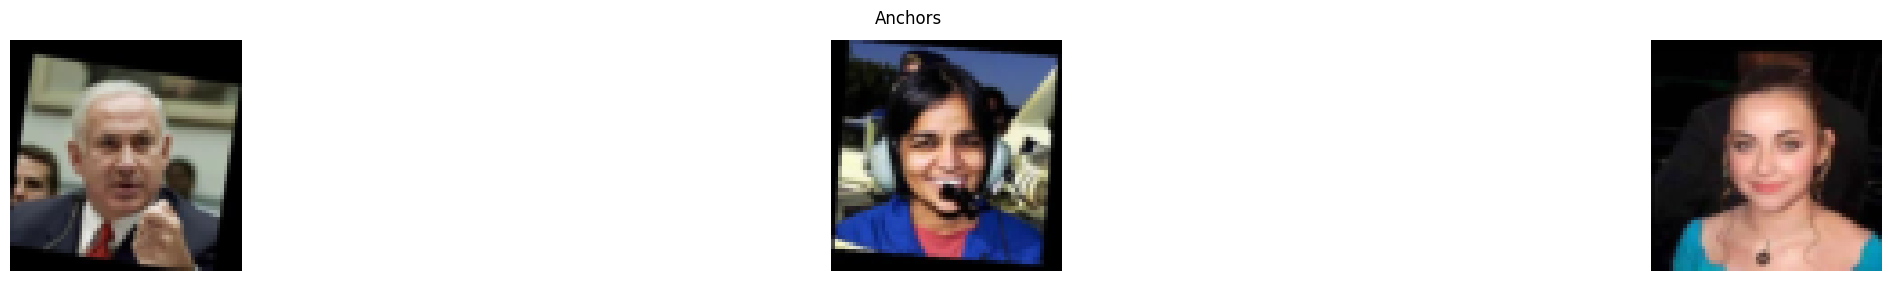

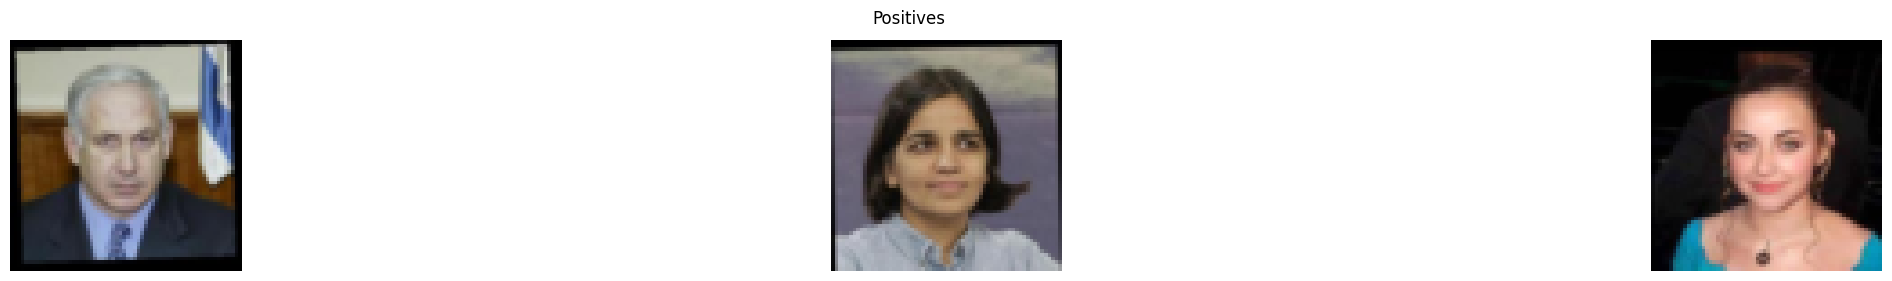

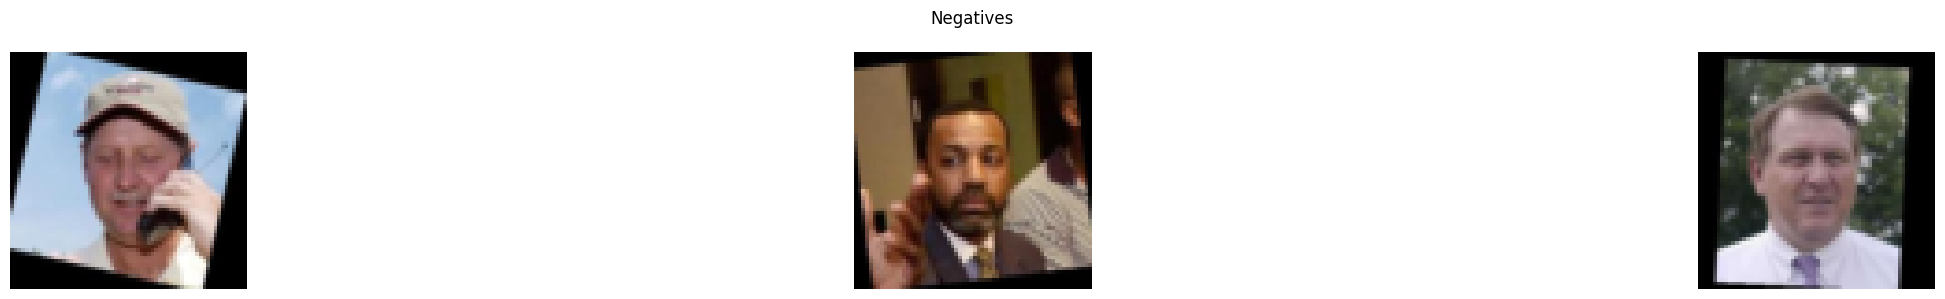

In [19]:
SUBPLOT_COUNT = 3

fig_anchors, anchors = plt.subplots(1, SUBPLOT_COUNT, figsize=(30, 3))
fig_pos, positives = plt.subplots(1, SUBPLOT_COUNT, figsize=(30, 3))
fig_neg, negatives = plt.subplots(1, SUBPLOT_COUNT, figsize=(30, 3))

for i in range(SUBPLOT_COUNT):
    (anchor, positive, negative), _ = train_dataset[i]
    
    # [C, H, W] -> [H, W, C] for matplotlib
    anchors[i].imshow(anchor.permute(1, 2, 0).numpy())
    anchors[i].axis("off")
    
    positives[i].imshow(positive.permute(1, 2, 0).numpy())
    positives[i].axis("off")
    
    negatives[i].imshow(negative.permute(1, 2, 0).numpy())
    negatives[i].axis("off")

fig_anchors.suptitle("Anchors")
fig_pos.suptitle("Positives")
fig_neg.suptitle("Negatives")

plt.tight_layout()
plt.show()

In [8]:
BATCH_SIZE = 128

train_loader = torch.utils.data.DataLoader(dataset=train_dataset, batch_size=BATCH_SIZE, num_workers=4, shuffle=True) 
test_loader = torch.utils.data.DataLoader(dataset=test_dataset, batch_size=BATCH_SIZE, num_workers=4, shuffle=False) 

In [57]:
from models.SiameseModel import SiameseModel
from TripletLoss import TripletLoss
from train import Trainer

In [ ]:
SiameseModel()

/home/user/imashevv1/CudaLabSS25/venv/lib/python3.8/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/user/imashevv1/CudaLabSS25/venv/lib/python3.8/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


SiameseModel(
  (backbone): ResNetBackbone(
    (feature_extractor): Sequential(
      (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=True)
      (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
      (4): Sequential(
        (0): BasicBlock(
          (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (relu): ReLU(inplace=True)
          (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        )
        (1): BasicBlock(
          (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn1): Ba

#### Finding best margin

In [10]:
ITERATIONS = 1e4
# margins = [.1, .2, .3]
margins = [.4, .5, 1.0]

for margin in margins:
    print(f"Launching experiments with margin={margin}")
    model_logs = datetime.now().strftime(f"m{margin}-%H-%M_%d-%m-%Y")
    TBOARD_LOGS = os.path.join(os.getcwd(), "tboard_logs", "Siamese", model_logs)
    os.makedirs(TBOARD_LOGS, exist_ok=True)
    writer = SummaryWriter(TBOARD_LOGS)

    model = SiameseModel()
    criterion = TripletLoss(margin)
    trainer = Trainer(model=model, criterion=criterion, writer=writer,
                      train_loader=train_loader, valid_loader=test_loader, n_iters=ITERATIONS)
    trainer.fit()
    save_model(model, f"Siamese_m{margin}_iter{ITERATIONS}")
    print()

Launching experiments with margin=0.4


/home/user/kellerv1/miniforge3/envs/lab/lib/python3.12/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/user/kellerv1/miniforge3/envs/lab/lib/python3.12/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Train Iter 4: Loss=0.20119):   0%|          | 0/10000 [00:03<?, ?it/s]

Valid loss @ iteration 0: Loss=0.1288292674081666


Train Iter 254: Loss=0.02414):   0%|          | 0/10000 [00:33<?, ?it/s]

Valid loss @ iteration 250: Loss=0.040119676739864406


Train Iter 505: Loss=0.02978):   0%|          | 0/10000 [01:01<?, ?it/s]

Valid loss @ iteration 500: Loss=0.03802836712981973


Train Iter 755: Loss=0.02855):   0%|          | 0/10000 [01:22<?, ?it/s]

Valid loss @ iteration 750: Loss=0.031866755425220446


Train Iter 1005: Loss=0.00413):   0%|          | 0/10000 [01:43<?, ?it/s]

Valid loss @ iteration 1000: Loss=0.03618067582803113


Train Iter 1255: Loss=0.03093):   0%|          | 0/10000 [02:05<?, ?it/s]

Valid loss @ iteration 1250: Loss=0.03113900062938531


Train Iter 1505: Loss=0.01578):   0%|          | 0/10000 [02:26<?, ?it/s]

Valid loss @ iteration 1500: Loss=0.02505319522294615


Train Iter 1755: Loss=0.0127):   0%|          | 0/10000 [02:47<?, ?it/s] 

Valid loss @ iteration 1750: Loss=0.028395581724388257


Train Iter 2005: Loss=0.01566):   0%|          | 0/10000 [03:08<?, ?it/s]

Valid loss @ iteration 2000: Loss=0.02691342876780601


Train Iter 2255: Loss=0.00873):   0%|          | 0/10000 [03:30<?, ?it/s]

Valid loss @ iteration 2250: Loss=0.027543530267264162


Train Iter 2505: Loss=0.01509):   0%|          | 0/10000 [03:52<?, ?it/s]

Valid loss @ iteration 2500: Loss=0.02691741988417648


Train Iter 2755: Loss=0.01219):   0%|          | 0/10000 [04:13<?, ?it/s]

Valid loss @ iteration 2750: Loss=0.02711200678632373


Train Iter 3005: Loss=0.00821):   0%|          | 0/10000 [04:34<?, ?it/s]

Valid loss @ iteration 3000: Loss=0.0241473445314027


Train Iter 3255: Loss=0.00229):   0%|          | 0/10000 [04:55<?, ?it/s]

Valid loss @ iteration 3250: Loss=0.01793994621506759


Train Iter 3505: Loss=0.00942):   0%|          | 0/10000 [05:16<?, ?it/s]

Valid loss @ iteration 3500: Loss=0.020105291069263502


Train Iter 3755: Loss=0.00926):   0%|          | 0/10000 [05:38<?, ?it/s]

Valid loss @ iteration 3750: Loss=0.023596296840835185


Train Iter 4005: Loss=0.01558):   0%|          | 0/10000 [05:59<?, ?it/s]

Valid loss @ iteration 4000: Loss=0.025303201306433903


Train Iter 4255: Loss=0.00516):   0%|          | 0/10000 [06:20<?, ?it/s]

Valid loss @ iteration 4250: Loss=0.023816347787422792


Train Iter 4505: Loss=0.00387):   0%|          | 0/10000 [06:41<?, ?it/s]

Valid loss @ iteration 4500: Loss=0.024893764982975665


Train Iter 4755: Loss=0.0):   0%|          | 0/10000 [07:03<?, ?it/s]    

Valid loss @ iteration 4750: Loss=0.02328397251576895


Train Iter 5005: Loss=0.00665):   0%|          | 0/10000 [07:24<?, ?it/s]

Valid loss @ iteration 5000: Loss=0.021264158455388888


Train Iter 5255: Loss=0.00389):   0%|          | 0/10000 [07:45<?, ?it/s]

Valid loss @ iteration 5250: Loss=0.023120971518524346


Train Iter 5505: Loss=0.00275):   0%|          | 0/10000 [08:06<?, ?it/s]

Valid loss @ iteration 5500: Loss=0.022004630760334078


Train Iter 5755: Loss=0.00479):   0%|          | 0/10000 [08:28<?, ?it/s]

Valid loss @ iteration 5750: Loss=0.02435130129257838


Train Iter 6005: Loss=0.00472):   0%|          | 0/10000 [08:49<?, ?it/s]

Valid loss @ iteration 6000: Loss=0.022873172403446267


Train Iter 6255: Loss=0.00596):   0%|          | 0/10000 [09:10<?, ?it/s]

Valid loss @ iteration 6250: Loss=0.02191708703702759


Train Iter 6505: Loss=0.00674):   0%|          | 0/10000 [09:31<?, ?it/s]

Valid loss @ iteration 6500: Loss=0.02041673500623022


Train Iter 6755: Loss=0.01089):   0%|          | 0/10000 [09:52<?, ?it/s]

Valid loss @ iteration 6750: Loss=0.01932509077180709


Train Iter 7005: Loss=0.00108):   0%|          | 0/10000 [10:14<?, ?it/s]

Valid loss @ iteration 7000: Loss=0.024573969388646737


Train Iter 7255: Loss=0.00509):   0%|          | 0/10000 [10:35<?, ?it/s]

Valid loss @ iteration 7250: Loss=0.021251715819484422


Train Iter 7505: Loss=0.01028):   0%|          | 0/10000 [10:56<?, ?it/s]

Valid loss @ iteration 7500: Loss=0.021098593449486152


Train Iter 7755: Loss=0.01228):   0%|          | 0/10000 [11:17<?, ?it/s]

Valid loss @ iteration 7750: Loss=0.025658607893135576


Train Iter 8005: Loss=0.00875):   0%|          | 0/10000 [11:39<?, ?it/s]

Valid loss @ iteration 8000: Loss=0.02484566190590461


Train Iter 8255: Loss=0.00251):   0%|          | 0/10000 [12:00<?, ?it/s]

Valid loss @ iteration 8250: Loss=0.021474343635851427


Train Iter 8505: Loss=0.00317):   0%|          | 0/10000 [12:21<?, ?it/s]

Valid loss @ iteration 8500: Loss=0.024333170393393153


Train Iter 8755: Loss=0.00295):   0%|          | 0/10000 [12:43<?, ?it/s]

Valid loss @ iteration 8750: Loss=0.020367611554406938


Train Iter 9005: Loss=0.00652):   0%|          | 0/10000 [13:04<?, ?it/s]

Valid loss @ iteration 9000: Loss=0.024214845416801318


Train Iter 9255: Loss=0.00609):   0%|          | 0/10000 [13:25<?, ?it/s]

Valid loss @ iteration 9250: Loss=0.018687948008023557


Train Iter 9505: Loss=0.0):   0%|          | 0/10000 [13:46<?, ?it/s]    

Valid loss @ iteration 9500: Loss=0.024035993431295668


Train Iter 9755: Loss=0.00293):   0%|          | 0/10000 [14:07<?, ?it/s]

Valid loss @ iteration 9750: Loss=0.019574219183552833


Train Iter 9999: Loss=0.0046):   0%|          | 0/10000 [14:27<?, ?it/s] 


Saved state to checkpoints/Siamese_m0.4_iter10000.0.pth

Launching experiments with margin=0.5


Train Iter 5: Loss=0.21586):   0%|          | 0/10000 [00:02<?, ?it/s]

Valid loss @ iteration 0: Loss=0.16312833698022933


Train Iter 255: Loss=0.09017):   0%|          | 0/10000 [00:23<?, ?it/s]

Valid loss @ iteration 250: Loss=0.06333969409267108


Train Iter 505: Loss=0.05853):   0%|          | 0/10000 [00:44<?, ?it/s]

Valid loss @ iteration 500: Loss=0.04213956956352506


Train Iter 755: Loss=0.02781):   0%|          | 0/10000 [01:06<?, ?it/s]

Valid loss @ iteration 750: Loss=0.03743582405149937


Train Iter 1005: Loss=0.00591):   0%|          | 0/10000 [01:27<?, ?it/s]

Valid loss @ iteration 1000: Loss=0.03883574295434214


Train Iter 1255: Loss=0.00443):   0%|          | 0/10000 [01:49<?, ?it/s]

Valid loss @ iteration 1250: Loss=0.03006402997388726


Train Iter 1505: Loss=0.02753):   0%|          | 0/10000 [02:10<?, ?it/s]

Valid loss @ iteration 1500: Loss=0.03407683507317588


Train Iter 1755: Loss=0.0108):   0%|          | 0/10000 [02:31<?, ?it/s] 

Valid loss @ iteration 1750: Loss=0.03062849203568129


Train Iter 2005: Loss=0.01893):   0%|          | 0/10000 [02:52<?, ?it/s]

Valid loss @ iteration 2000: Loss=0.028248663725597516


Train Iter 2255: Loss=0.01743):   0%|          | 0/10000 [03:14<?, ?it/s]

Valid loss @ iteration 2250: Loss=0.03574902770508613


Train Iter 2505: Loss=0.00669):   0%|          | 0/10000 [03:35<?, ?it/s]

Valid loss @ iteration 2500: Loss=0.03456416353583336


Train Iter 2755: Loss=0.00571):   0%|          | 0/10000 [03:56<?, ?it/s]

Valid loss @ iteration 2750: Loss=0.03543131434846492


Train Iter 3005: Loss=0.01561):   0%|          | 0/10000 [04:18<?, ?it/s]

Valid loss @ iteration 3000: Loss=0.03286104942006724


Train Iter 3255: Loss=0.01337):   0%|          | 0/10000 [04:39<?, ?it/s]

Valid loss @ iteration 3250: Loss=0.03087627391020457


Train Iter 3505: Loss=0.00023):   0%|          | 0/10000 [05:00<?, ?it/s]

Valid loss @ iteration 3500: Loss=0.03056729482930331


Train Iter 3755: Loss=0.00479):   0%|          | 0/10000 [05:21<?, ?it/s]

Valid loss @ iteration 3750: Loss=0.029662052568580424


Train Iter 4005: Loss=0.01238):   0%|          | 0/10000 [05:44<?, ?it/s]

Valid loss @ iteration 4000: Loss=0.03663212885814054


Train Iter 4255: Loss=0.01551):   0%|          | 0/10000 [06:06<?, ?it/s]

Valid loss @ iteration 4250: Loss=0.030766661766739117


Train Iter 4505: Loss=0.01768):   0%|          | 0/10000 [06:27<?, ?it/s]

Valid loss @ iteration 4500: Loss=0.028907308576717264


Train Iter 4755: Loss=0.00698):   0%|          | 0/10000 [06:48<?, ?it/s]

Valid loss @ iteration 4750: Loss=0.030072535742961225


Train Iter 5005: Loss=0.00374):   0%|          | 0/10000 [07:10<?, ?it/s]

Valid loss @ iteration 5000: Loss=0.029385371399777278


Train Iter 5255: Loss=0.00925):   0%|          | 0/10000 [07:31<?, ?it/s]

Valid loss @ iteration 5250: Loss=0.02897479584706681


Train Iter 5505: Loss=0.00573):   0%|          | 0/10000 [07:53<?, ?it/s]

Valid loss @ iteration 5500: Loss=0.026347134084928604


Train Iter 5755: Loss=0.00594):   0%|          | 0/10000 [08:14<?, ?it/s]

Valid loss @ iteration 5750: Loss=0.03025690253291811


Train Iter 6005: Loss=0.01021):   0%|          | 0/10000 [08:35<?, ?it/s]

Valid loss @ iteration 6000: Loss=0.027334137420569147


Train Iter 6255: Loss=0.00739):   0%|          | 0/10000 [08:56<?, ?it/s]

Valid loss @ iteration 6250: Loss=0.03269032326837381


Train Iter 6505: Loss=0.0101):   0%|          | 0/10000 [09:18<?, ?it/s] 

Valid loss @ iteration 6500: Loss=0.026267284837861855


Train Iter 6755: Loss=0.00254):   0%|          | 0/10000 [09:39<?, ?it/s]

Valid loss @ iteration 6750: Loss=0.03973889814334966


Train Iter 7005: Loss=0.0132):   0%|          | 0/10000 [10:00<?, ?it/s] 

Valid loss @ iteration 7000: Loss=0.030660673842898438


Train Iter 7255: Loss=0.00117):   0%|          | 0/10000 [10:21<?, ?it/s]

Valid loss @ iteration 7250: Loss=0.026912890862496125


Train Iter 7505: Loss=0.00933):   0%|          | 0/10000 [10:43<?, ?it/s]

Valid loss @ iteration 7500: Loss=0.033951187772410255


Train Iter 7755: Loss=0.01226):   0%|          | 0/10000 [11:04<?, ?it/s]

Valid loss @ iteration 7750: Loss=0.029370565455229508


Train Iter 8005: Loss=0.00419):   0%|          | 0/10000 [11:25<?, ?it/s]

Valid loss @ iteration 8000: Loss=0.032262421967018215


Train Iter 8255: Loss=0.00082):   0%|          | 0/10000 [11:46<?, ?it/s]

Valid loss @ iteration 8250: Loss=0.03110416473022529


Train Iter 8505: Loss=0.00141):   0%|          | 0/10000 [12:07<?, ?it/s]

Valid loss @ iteration 8500: Loss=0.029930945042343365


Train Iter 8755: Loss=0.00519):   0%|          | 0/10000 [12:29<?, ?it/s]

Valid loss @ iteration 8750: Loss=0.03037664085803997


Train Iter 9005: Loss=0.00676):   0%|          | 0/10000 [12:50<?, ?it/s]

Valid loss @ iteration 9000: Loss=0.023806520072477206


Train Iter 9255: Loss=0.0):   0%|          | 0/10000 [13:11<?, ?it/s]    

Valid loss @ iteration 9250: Loss=0.029842356419456855


Train Iter 9505: Loss=0.00202):   0%|          | 0/10000 [13:33<?, ?it/s]

Valid loss @ iteration 9500: Loss=0.022476205380544775


Train Iter 9755: Loss=0.00786):   0%|          | 0/10000 [13:55<?, ?it/s]

Valid loss @ iteration 9750: Loss=0.025123045402800755


Train Iter 9999: Loss=0.00151):   0%|          | 0/10000 [14:14<?, ?it/s]


Saved state to checkpoints/Siamese_m0.5_iter10000.0.pth

Launching experiments with margin=1.0


Train Iter 5: Loss=0.49251):   0%|          | 0/10000 [00:02<?, ?it/s]

Valid loss @ iteration 0: Loss=0.505874304544358


Train Iter 255: Loss=0.10203):   0%|          | 0/10000 [00:24<?, ?it/s]

Valid loss @ iteration 250: Loss=0.12199599934475762


Train Iter 505: Loss=0.06677):   0%|          | 0/10000 [00:45<?, ?it/s]

Valid loss @ iteration 500: Loss=0.12612931288423992


Train Iter 755: Loss=0.0664):   0%|          | 0/10000 [01:06<?, ?it/s] 

Valid loss @ iteration 750: Loss=0.09924128421005748


Train Iter 1005: Loss=0.02413):   0%|          | 0/10000 [01:28<?, ?it/s]

Valid loss @ iteration 1000: Loss=0.09844855307823136


Train Iter 1255: Loss=0.05148):   0%|          | 0/10000 [01:49<?, ?it/s]

Valid loss @ iteration 1250: Loss=0.09833414870358649


Train Iter 1505: Loss=0.04459):   0%|          | 0/10000 [02:10<?, ?it/s]

Valid loss @ iteration 1500: Loss=0.10014978086664564


Train Iter 1755: Loss=0.02702):   0%|          | 0/10000 [02:32<?, ?it/s]

Valid loss @ iteration 1750: Loss=0.1000744178891182


Train Iter 2005: Loss=0.02856):   0%|          | 0/10000 [02:54<?, ?it/s]

Valid loss @ iteration 2000: Loss=0.09282330476811954


Train Iter 2255: Loss=0.02385):   0%|          | 0/10000 [03:16<?, ?it/s]

Valid loss @ iteration 2250: Loss=0.0892353304440067


Train Iter 2505: Loss=0.04269):   0%|          | 0/10000 [03:37<?, ?it/s]

Valid loss @ iteration 2500: Loss=0.08844788603129841


Train Iter 2755: Loss=0.04595):   0%|          | 0/10000 [03:59<?, ?it/s]

Valid loss @ iteration 2750: Loss=0.0955715835804031


Train Iter 3005: Loss=0.02862):   0%|          | 0/10000 [04:21<?, ?it/s]

Valid loss @ iteration 3000: Loss=0.08660388684698514


Train Iter 3255: Loss=0.02265):   0%|          | 0/10000 [04:43<?, ?it/s]

Valid loss @ iteration 3250: Loss=0.0861468483649549


Train Iter 3505: Loss=0.02577):   0%|          | 0/10000 [05:04<?, ?it/s]

Valid loss @ iteration 3500: Loss=0.08218269883876755


Train Iter 3755: Loss=0.01782):   0%|          | 0/10000 [05:25<?, ?it/s]

Valid loss @ iteration 3750: Loss=0.07911533472083863


Train Iter 4005: Loss=0.02498):   0%|          | 0/10000 [05:46<?, ?it/s]

Valid loss @ iteration 4000: Loss=0.09084866834538323


Train Iter 4255: Loss=0.01286):   0%|          | 0/10000 [06:08<?, ?it/s]

Valid loss @ iteration 4250: Loss=0.08385471023973964


Train Iter 4505: Loss=0.01766):   0%|          | 0/10000 [06:29<?, ?it/s]

Valid loss @ iteration 4500: Loss=0.08210504764602297


Train Iter 4755: Loss=0.01042):   0%|          | 0/10000 [06:51<?, ?it/s]

Valid loss @ iteration 4750: Loss=0.08194710580365998


Train Iter 5005: Loss=0.03345):   0%|          | 0/10000 [07:12<?, ?it/s]

Valid loss @ iteration 5000: Loss=0.09109462442852202


Train Iter 5255: Loss=0.01149):   0%|          | 0/10000 [07:33<?, ?it/s]

Valid loss @ iteration 5250: Loss=0.09293585518995921


Train Iter 5505: Loss=0.01553):   0%|          | 0/10000 [07:54<?, ?it/s]

Valid loss @ iteration 5500: Loss=0.08497651524486996


Train Iter 5755: Loss=0.02954):   0%|          | 0/10000 [08:16<?, ?it/s]

Valid loss @ iteration 5750: Loss=0.09118340554691497


Train Iter 6005: Loss=0.01799):   0%|          | 0/10000 [08:37<?, ?it/s]

Valid loss @ iteration 6000: Loss=0.08319064744171642


Train Iter 6255: Loss=0.02149):   0%|          | 0/10000 [08:58<?, ?it/s]

Valid loss @ iteration 6250: Loss=0.08450163067096755


Train Iter 6505: Loss=0.01888):   0%|          | 0/10000 [09:20<?, ?it/s]

Valid loss @ iteration 6500: Loss=0.09125615957947004


Train Iter 6755: Loss=0.01566):   0%|          | 0/10000 [09:41<?, ?it/s]

Valid loss @ iteration 6750: Loss=0.0773043701691287


Train Iter 7005: Loss=0.01294):   0%|          | 0/10000 [10:02<?, ?it/s]

Valid loss @ iteration 7000: Loss=0.09978518138329188


Train Iter 7255: Loss=0.01083):   0%|          | 0/10000 [10:24<?, ?it/s]

Valid loss @ iteration 7250: Loss=0.08490369078658876


Train Iter 7505: Loss=0.01821):   0%|          | 0/10000 [10:45<?, ?it/s]

Valid loss @ iteration 7500: Loss=0.08528421854689008


Train Iter 7755: Loss=0.02166):   0%|          | 0/10000 [11:07<?, ?it/s]

Valid loss @ iteration 7750: Loss=0.08583195064039457


Train Iter 8005: Loss=0.00758):   0%|          | 0/10000 [11:28<?, ?it/s]

Valid loss @ iteration 8000: Loss=0.09435583384973663


Train Iter 8255: Loss=0.01239):   0%|          | 0/10000 [11:49<?, ?it/s]

Valid loss @ iteration 8250: Loss=0.08602013243805795


Train Iter 8505: Loss=0.02741):   0%|          | 0/10000 [12:10<?, ?it/s]

Valid loss @ iteration 8500: Loss=0.09380516090563365


Train Iter 8755: Loss=0.01016):   0%|          | 0/10000 [12:31<?, ?it/s]

Valid loss @ iteration 8750: Loss=0.09761373095569156


Train Iter 9005: Loss=0.0103):   0%|          | 0/10000 [12:53<?, ?it/s] 

Valid loss @ iteration 9000: Loss=0.08376024361877214


Train Iter 9255: Loss=0.01037):   0%|          | 0/10000 [13:14<?, ?it/s]

Valid loss @ iteration 9250: Loss=0.08453236733164106


Train Iter 9505: Loss=0.01234):   0%|          | 0/10000 [13:36<?, ?it/s]

Valid loss @ iteration 9500: Loss=0.0937062008749871


Train Iter 9755: Loss=0.01925):   0%|          | 0/10000 [13:57<?, ?it/s]

Valid loss @ iteration 9750: Loss=0.07446479779623803


Train Iter 9999: Loss=0.01038):   0%|          | 0/10000 [14:16<?, ?it/s]

Saved state to checkpoints/Siamese_m1.0_iter10000.0.pth



### Model with best margin

In [31]:
best_model_name = "Siamese_m0.4_iter10000.0"

best_model = SiameseModel()
load_model(best_model, best_model_name)
best_model.to(device)

/home/user/kellerv1/miniforge3/envs/lab/lib/python3.12/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/user/kellerv1/miniforge3/envs/lab/lib/python3.12/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


SiameseModel(
  (backbone): ResNetBackbone(
    (feature_extractor): Sequential(
      (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=True)
      (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
      (4): Sequential(
        (0): BasicBlock(
          (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (relu): ReLU(inplace=True)
          (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        )
        (1): BasicBlock(
          (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn1): Ba

In [33]:
import numpy as np

with torch.no_grad():
    train_loss = []

    for (anchors, positives, negatives), _ in test_loader:     
        anchors = anchors.to(device)
        positives = positives.to(device)
        negatives = negatives.to(device)
        
        anchor_emb, positive_emb, negative_emb = best_model(anchors, positives, negatives)
        loss = criterion(anchor_emb, positive_emb, negative_emb)
        train_loss.append(loss.item())
    
    print(f"Loss for {best_model_name}:", np.mean(train_loss))

Loss for Siamese_m0.4_iter10000.0: 0.06951225823944523


```
Loss for Siamese_m0.2_iter10000.0: 0.09239480200977553
Loss for Siamese_m0.1_iter10000.0: 0.24007738488061087
Loss for Siamese_m0.3_iter10000.0: 0.08845916993561245
Loss for Siamese_m0.4_iter10000.0: 0.07009460901220639
Loss for Siamese_m0.5_iter10000.0: 0.07096759087982632
Loss for Siamese_m1.0_iter10000.0: 0.0800417565873691
```

We selected model with margin = .4 since it produced the lowest loss value.

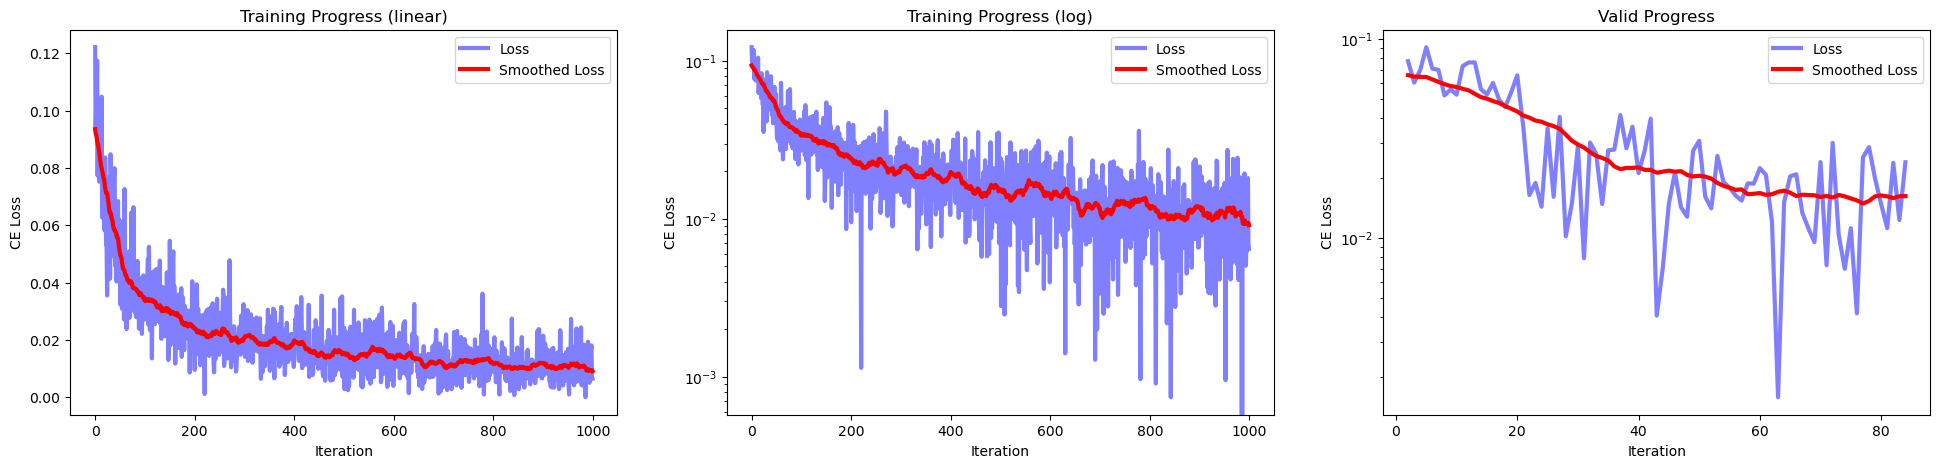

In [ ]:
# from utils.visualize_progress import visualize_progress

# visualize_progress(trainer.train_loss, trainer.valid_loss, start=1)
# plt.show()

### SimCLR model

In [7]:
from SimCLRDataset import SimCLRDataset

BATCH_SIZE = 128
simclr_db = SimCLRDataset(lfw_dataset)
data_loader = torch.utils.data.DataLoader(
        simclr_db,
        batch_size=BATCH_SIZE,
        shuffle=True,
        num_workers=4
    )

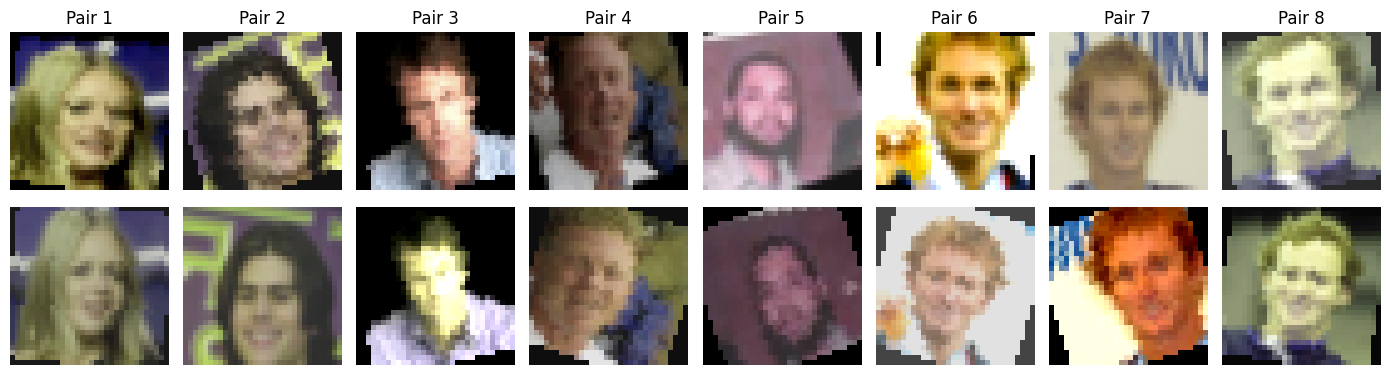

In [8]:
%matplotlib inline
import matplotlib
from matplotlib import pyplot as plt
matplotlib.style.use('default')

fig, ax = plt.subplots(2, 8)
fig.set_size_inches(14, 4)
for i in range(8):
    view1, view2 = simclr_db[i]
    ax[0, i].imshow(view1.permute(1, 2, 0))
    ax[1, i].imshow(view2.permute(1, 2, 0))
    ax[0, i].axis("off")
    ax[1, i].axis("off")
    ax[0, i].set_title(f"Pair {i+1}")

plt.tight_layout()
plt.show()

In [9]:
import torch.nn.functional as F

def nt_xent_loss(z_i, z_j, temperature=0.1):
    """
    Normalized Temperature-scaled Cross Entropy Loss
    """
    B, dim = z_i.shape
    
    # Concatenate positive pairs
    z = torch.cat([z_i, z_j], dim=0)  # Shape: (2 * B, dim)
    # Compute similarity matrix
    sim_matrix = torch.mm(z, z.T) / temperature  # Shape: (2 * B, 2 * B)
    
    # Mask to remove self-similarity (diagonal)
    mask = torch.eye(2 * B, dtype=torch.bool).to(z.device)
    sim_matrix_final = sim_matrix.masked_fill(mask, float('-inf'))
    sim_matrix_vis = sim_matrix

    positives_labels = torch.cat([torch.arange(B, 2*B), torch.arange(0, B)]).to(z.device)

    # Compute cross entropy loss
    loss = F.cross_entropy(sim_matrix_final, positives_labels, reduction="mean")
    return loss, sim_matrix_vis

In [20]:
from tqdm import tqdm
from models.SimCLR import SimCLR

NUM_EPOCHS = int(100)
LR = 1e-3
temperatures = [.07, .1, .8]


simclr_dataset = SimCLRDataset(lfw_dataset)

train_loader = torch.utils.data.DataLoader(
    simclr_dataset,
    batch_size=BATCH_SIZE,
    shuffle=True,
    num_workers=4,
    pin_memory=True
)


for temperature in temperatures:
    print(f"Launching experiments with temperature={temperature}")
    model_logs = datetime.now().strftime(f"temp{temperature}-%H-%M_%d-%m-%Y")
    TBOARD_LOGS = os.path.join(os.getcwd(), "tboard_logs", "SimCLR", model_logs)
    os.makedirs(TBOARD_LOGS, exist_ok=True)
    writer = SummaryWriter(TBOARD_LOGS)

    model = SimCLR().to(device)
    optimizer = torch.optim.Adam(model.parameters(), lr=LR)

    for epoch in range(NUM_EPOCHS):
        model.train()
        epoch_loss = 0.0

        for batch_idx, (x_i, x_j) in enumerate(tqdm(train_loader)):
            x_i, x_j = x_i.to(device), x_j.to(device)

            # Forward pass
            z_i = model(x_i)
            z_j = model(x_j)

            # Loss
            loss, _ = nt_xent_loss(z_i, z_j, temperature)

            # Backward pass
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            epoch_loss += loss.item()
            

            if batch_idx % 100 == 0:
                print(f'Epoch {epoch+1}/{NUM_EPOCHS}, Batch {batch_idx}, Loss: {loss.item():.4f}')

        avg_loss = epoch_loss / len(train_loader)
        writer.add_scalar("Loss", avg_loss, global_step=epoch)
        print(f"Epoch {epoch+1} complete. Average Loss: {avg_loss:.4f}")

    save_model(model, f"SimCLR_t{temperature}_iter{NUM_EPOCHS}")
    print()

Launching experiments with temperature=0.07


  1%|█▏                                                                                                                      | 1/104 [00:00<01:10,  1.46it/s]

Epoch 1/100, Batch 0, Loss: 5.6148


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 104/104 [00:08<00:00, 12.81it/s]


Epoch 1/100, Batch 100, Loss: 3.0507
Epoch 1 complete. Average Loss: 3.5858


  1%|█▏                                                                                                                      | 1/104 [00:00<00:42,  2.44it/s]

Epoch 2/100, Batch 0, Loss: 2.7674


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 104/104 [00:08<00:00, 13.00it/s]


Epoch 2/100, Batch 100, Loss: 2.0297
Epoch 2 complete. Average Loss: 2.3528


  1%|█▏                                                                                                                      | 1/104 [00:00<00:39,  2.58it/s]

Epoch 3/100, Batch 0, Loss: 1.7788


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 104/104 [00:07<00:00, 13.50it/s]


Epoch 3/100, Batch 100, Loss: 1.5284
Epoch 3 complete. Average Loss: 1.7757


  1%|█▏                                                                                                                      | 1/104 [00:00<00:41,  2.45it/s]

Epoch 4/100, Batch 0, Loss: 1.9469


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 104/104 [00:07<00:00, 13.45it/s]


Epoch 4/100, Batch 100, Loss: 1.4531
Epoch 4 complete. Average Loss: 1.5311


  1%|█▏                                                                                                                      | 1/104 [00:00<00:42,  2.40it/s]

Epoch 5/100, Batch 0, Loss: 1.4041


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 104/104 [00:08<00:00, 12.88it/s]


Epoch 5/100, Batch 100, Loss: 1.2922
Epoch 5 complete. Average Loss: 1.3212


  1%|█▏                                                                                                                      | 1/104 [00:00<00:39,  2.58it/s]

Epoch 6/100, Batch 0, Loss: 1.1142


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 104/104 [00:07<00:00, 13.28it/s]


Epoch 6/100, Batch 100, Loss: 1.0106
Epoch 6 complete. Average Loss: 1.2094


  1%|█▏                                                                                                                      | 1/104 [00:00<00:46,  2.20it/s]

Epoch 7/100, Batch 0, Loss: 1.1784


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 104/104 [00:08<00:00, 12.71it/s]


Epoch 7/100, Batch 100, Loss: 1.1101
Epoch 7 complete. Average Loss: 1.0712


  1%|█▏                                                                                                                      | 1/104 [00:00<00:42,  2.41it/s]

Epoch 8/100, Batch 0, Loss: 1.0852


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 104/104 [00:08<00:00, 12.93it/s]


Epoch 8/100, Batch 100, Loss: 0.9806
Epoch 8 complete. Average Loss: 0.9746


  1%|█▏                                                                                                                      | 1/104 [00:00<00:42,  2.44it/s]

Epoch 9/100, Batch 0, Loss: 0.7592


 94%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏      | 98/104 [00:07<00:00, 13.63it/s]

Epoch 9/100, Batch 100, Loss: 0.7706


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 104/104 [00:08<00:00, 12.92it/s]


Epoch 9 complete. Average Loss: 0.8897


  1%|█▏                                                                                                                      | 1/104 [00:00<00:40,  2.53it/s]

Epoch 10/100, Batch 0, Loss: 0.9058


 95%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎     | 99/104 [00:07<00:00, 13.45it/s]

Epoch 10/100, Batch 100, Loss: 1.0003


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 104/104 [00:07<00:00, 13.25it/s]


Epoch 10 complete. Average Loss: 0.8347


  1%|█▏                                                                                                                      | 1/104 [00:00<00:41,  2.50it/s]

Epoch 11/100, Batch 0, Loss: 0.8835


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 104/104 [00:07<00:00, 13.29it/s]


Epoch 11/100, Batch 100, Loss: 0.6663
Epoch 11 complete. Average Loss: 0.7651


  1%|█▏                                                                                                                      | 1/104 [00:00<00:48,  2.11it/s]

Epoch 12/100, Batch 0, Loss: 0.7277


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 104/104 [00:08<00:00, 12.88it/s]


Epoch 12/100, Batch 100, Loss: 0.6705
Epoch 12 complete. Average Loss: 0.7319


  1%|█▏                                                                                                                      | 1/104 [00:00<00:42,  2.44it/s]

Epoch 13/100, Batch 0, Loss: 0.6670


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 104/104 [00:08<00:00, 12.11it/s]


Epoch 13/100, Batch 100, Loss: 0.6086
Epoch 13 complete. Average Loss: 0.6821


  1%|█▏                                                                                                                      | 1/104 [00:00<00:41,  2.48it/s]

Epoch 14/100, Batch 0, Loss: 0.7349


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 104/104 [00:08<00:00, 12.74it/s]


Epoch 14/100, Batch 100, Loss: 0.7142
Epoch 14 complete. Average Loss: 0.6803


  1%|█▏                                                                                                                      | 1/104 [00:00<00:42,  2.44it/s]

Epoch 15/100, Batch 0, Loss: 0.7998


 98%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋  | 102/104 [00:08<00:00, 13.42it/s]

Epoch 15/100, Batch 100, Loss: 0.6722


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 104/104 [00:08<00:00, 12.86it/s]


Epoch 15 complete. Average Loss: 0.6441


  1%|█▏                                                                                                                      | 1/104 [00:00<00:42,  2.40it/s]

Epoch 16/100, Batch 0, Loss: 0.5843


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 104/104 [00:07<00:00, 13.10it/s]


Epoch 16/100, Batch 100, Loss: 0.7318
Epoch 16 complete. Average Loss: 0.6132


  1%|█▏                                                                                                                      | 1/104 [00:00<00:41,  2.48it/s]

Epoch 17/100, Batch 0, Loss: 0.4851


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 104/104 [00:07<00:00, 13.33it/s]


Epoch 17/100, Batch 100, Loss: 0.6959
Epoch 17 complete. Average Loss: 0.5761


  1%|█▏                                                                                                                      | 1/104 [00:00<00:42,  2.42it/s]

Epoch 18/100, Batch 0, Loss: 0.4841


 98%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋  | 102/104 [00:07<00:00, 13.40it/s]

Epoch 18/100, Batch 100, Loss: 0.5747


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 104/104 [00:07<00:00, 13.16it/s]


Epoch 18 complete. Average Loss: 0.5478


  1%|█▏                                                                                                                      | 1/104 [00:00<00:42,  2.45it/s]

Epoch 19/100, Batch 0, Loss: 0.6437


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 104/104 [00:08<00:00, 12.93it/s]


Epoch 19/100, Batch 100, Loss: 0.4608
Epoch 19 complete. Average Loss: 0.5237


  1%|█▏                                                                                                                      | 1/104 [00:00<00:44,  2.30it/s]

Epoch 20/100, Batch 0, Loss: 0.6516


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 104/104 [00:08<00:00, 12.96it/s]


Epoch 20/100, Batch 100, Loss: 0.4276
Epoch 20 complete. Average Loss: 0.4750


  1%|█▏                                                                                                                      | 1/104 [00:00<00:42,  2.40it/s]

Epoch 21/100, Batch 0, Loss: 0.3990


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 104/104 [00:08<00:00, 12.78it/s]


Epoch 21/100, Batch 100, Loss: 0.5086
Epoch 21 complete. Average Loss: 0.4835


  1%|█▏                                                                                                                      | 1/104 [00:00<00:47,  2.16it/s]

Epoch 22/100, Batch 0, Loss: 0.3845


 94%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏      | 98/104 [00:07<00:00, 13.09it/s]

Epoch 22/100, Batch 100, Loss: 0.3960


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 104/104 [00:08<00:00, 12.71it/s]


Epoch 22 complete. Average Loss: 0.4608


  1%|█▏                                                                                                                      | 1/104 [00:00<00:46,  2.23it/s]

Epoch 23/100, Batch 0, Loss: 0.4765


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 104/104 [00:08<00:00, 12.92it/s]


Epoch 23/100, Batch 100, Loss: 0.4614
Epoch 23 complete. Average Loss: 0.4257


  1%|█▏                                                                                                                      | 1/104 [00:00<00:40,  2.53it/s]

Epoch 24/100, Batch 0, Loss: 0.3927


 95%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎     | 99/104 [00:07<00:00, 12.81it/s]

Epoch 24/100, Batch 100, Loss: 0.3524


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 104/104 [00:07<00:00, 13.31it/s]


Epoch 24 complete. Average Loss: 0.4294


  1%|█▏                                                                                                                      | 1/104 [00:00<00:42,  2.40it/s]

Epoch 25/100, Batch 0, Loss: 0.5139


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 104/104 [00:07<00:00, 13.23it/s]


Epoch 25/100, Batch 100, Loss: 0.3779
Epoch 25 complete. Average Loss: 0.4171


  1%|█▏                                                                                                                      | 1/104 [00:00<00:40,  2.53it/s]

Epoch 26/100, Batch 0, Loss: 0.4627


 95%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎     | 99/104 [00:07<00:00, 12.61it/s]

Epoch 26/100, Batch 100, Loss: 0.3972


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 104/104 [00:07<00:00, 13.31it/s]


Epoch 26 complete. Average Loss: 0.4016


  1%|█▏                                                                                                                      | 1/104 [00:00<00:41,  2.47it/s]

Epoch 27/100, Batch 0, Loss: 0.5469


 94%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏      | 98/104 [00:07<00:00, 13.28it/s]

Epoch 27/100, Batch 100, Loss: 0.4209


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 104/104 [00:08<00:00, 12.68it/s]


Epoch 27 complete. Average Loss: 0.3897


  1%|█▏                                                                                                                      | 1/104 [00:00<00:42,  2.43it/s]

Epoch 28/100, Batch 0, Loss: 0.3592


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 104/104 [00:07<00:00, 13.04it/s]


Epoch 28/100, Batch 100, Loss: 0.3104
Epoch 28 complete. Average Loss: 0.3784


  1%|█▏                                                                                                                      | 1/104 [00:00<00:42,  2.42it/s]

Epoch 29/100, Batch 0, Loss: 0.4671


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 104/104 [00:07<00:00, 13.22it/s]


Epoch 29/100, Batch 100, Loss: 0.3666
Epoch 29 complete. Average Loss: 0.3499


  1%|█▏                                                                                                                      | 1/104 [00:00<00:42,  2.42it/s]

Epoch 30/100, Batch 0, Loss: 0.2420


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 104/104 [00:07<00:00, 13.36it/s]


Epoch 30/100, Batch 100, Loss: 0.3387
Epoch 30 complete. Average Loss: 0.3771


  1%|█▏                                                                                                                      | 1/104 [00:00<00:41,  2.46it/s]

Epoch 31/100, Batch 0, Loss: 0.3351


 94%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏      | 98/104 [00:07<00:00, 13.05it/s]

Epoch 31/100, Batch 100, Loss: 0.3714


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 104/104 [00:08<00:00, 12.97it/s]


Epoch 31 complete. Average Loss: 0.3630


  1%|█▏                                                                                                                      | 1/104 [00:00<00:43,  2.36it/s]

Epoch 32/100, Batch 0, Loss: 0.3136


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 104/104 [00:07<00:00, 13.20it/s]


Epoch 32/100, Batch 100, Loss: 0.3276
Epoch 32 complete. Average Loss: 0.3413


  1%|█▏                                                                                                                      | 1/104 [00:00<00:41,  2.50it/s]

Epoch 33/100, Batch 0, Loss: 0.2958


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 104/104 [00:07<00:00, 13.18it/s]


Epoch 33/100, Batch 100, Loss: 0.3144
Epoch 33 complete. Average Loss: 0.3269


  1%|█▏                                                                                                                      | 1/104 [00:00<00:43,  2.38it/s]

Epoch 34/100, Batch 0, Loss: 0.2154


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 104/104 [00:07<00:00, 13.11it/s]


Epoch 34/100, Batch 100, Loss: 0.3115
Epoch 34 complete. Average Loss: 0.3248


  1%|█▏                                                                                                                      | 1/104 [00:00<00:41,  2.45it/s]

Epoch 35/100, Batch 0, Loss: 0.1988


 95%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎     | 99/104 [00:07<00:00, 13.24it/s]

Epoch 35/100, Batch 100, Loss: 0.3613


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 104/104 [00:08<00:00, 12.80it/s]


Epoch 35 complete. Average Loss: 0.3194


  1%|█▏                                                                                                                      | 1/104 [00:00<00:42,  2.45it/s]

Epoch 36/100, Batch 0, Loss: 0.3151


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 104/104 [00:07<00:00, 13.30it/s]


Epoch 36/100, Batch 100, Loss: 0.2531
Epoch 36 complete. Average Loss: 0.3185


  1%|█▏                                                                                                                      | 1/104 [00:00<00:42,  2.44it/s]

Epoch 37/100, Batch 0, Loss: 0.2843


 94%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏      | 98/104 [00:07<00:00, 13.60it/s]

Epoch 37/100, Batch 100, Loss: 0.3334


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 104/104 [00:07<00:00, 13.16it/s]


Epoch 37 complete. Average Loss: 0.3013


  1%|█▏                                                                                                                      | 1/104 [00:00<00:44,  2.31it/s]

Epoch 38/100, Batch 0, Loss: 0.1777


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 104/104 [00:07<00:00, 13.06it/s]


Epoch 38/100, Batch 100, Loss: 0.3267
Epoch 38 complete. Average Loss: 0.3008


  1%|█▏                                                                                                                      | 1/104 [00:00<00:42,  2.42it/s]

Epoch 39/100, Batch 0, Loss: 0.2978


 94%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏      | 98/104 [00:07<00:00, 12.12it/s]

Epoch 39/100, Batch 100, Loss: 0.4390


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 104/104 [00:08<00:00, 12.87it/s]


Epoch 39 complete. Average Loss: 0.3009


  1%|█▏                                                                                                                      | 1/104 [00:00<00:42,  2.42it/s]

Epoch 40/100, Batch 0, Loss: 0.2000


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 104/104 [00:07<00:00, 13.10it/s]


Epoch 40/100, Batch 100, Loss: 0.2609
Epoch 40 complete. Average Loss: 0.2901


  1%|█▏                                                                                                                      | 1/104 [00:00<00:43,  2.39it/s]

Epoch 41/100, Batch 0, Loss: 0.3614


 95%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎     | 99/104 [00:07<00:00, 13.43it/s]

Epoch 41/100, Batch 100, Loss: 0.2736


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 104/104 [00:08<00:00, 12.83it/s]


Epoch 41 complete. Average Loss: 0.2853


  1%|█▏                                                                                                                      | 1/104 [00:00<00:42,  2.45it/s]

Epoch 42/100, Batch 0, Loss: 0.2767


 94%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏      | 98/104 [00:07<00:00, 13.23it/s]

Epoch 42/100, Batch 100, Loss: 0.2460


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 104/104 [00:07<00:00, 13.32it/s]


Epoch 42 complete. Average Loss: 0.2802


  1%|█▏                                                                                                                      | 1/104 [00:00<00:43,  2.39it/s]

Epoch 43/100, Batch 0, Loss: 0.2694


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 104/104 [00:07<00:00, 13.35it/s]


Epoch 43/100, Batch 100, Loss: 0.2404
Epoch 43 complete. Average Loss: 0.2859


  1%|█▏                                                                                                                      | 1/104 [00:00<00:47,  2.19it/s]

Epoch 44/100, Batch 0, Loss: 0.3655


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 104/104 [00:08<00:00, 11.64it/s]


Epoch 44/100, Batch 100, Loss: 0.1782
Epoch 44 complete. Average Loss: 0.2668


  1%|█▏                                                                                                                      | 1/104 [00:00<00:41,  2.46it/s]

Epoch 45/100, Batch 0, Loss: 0.2884


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 104/104 [00:07<00:00, 13.40it/s]


Epoch 45/100, Batch 100, Loss: 0.2461
Epoch 45 complete. Average Loss: 0.2459


  1%|█▏                                                                                                                      | 1/104 [00:00<00:41,  2.46it/s]

Epoch 46/100, Batch 0, Loss: 0.2307


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 104/104 [00:07<00:00, 13.18it/s]


Epoch 46/100, Batch 100, Loss: 0.3812
Epoch 46 complete. Average Loss: 0.2427


  1%|█▏                                                                                                                      | 1/104 [00:00<00:46,  2.19it/s]

Epoch 47/100, Batch 0, Loss: 0.2675


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 104/104 [00:07<00:00, 13.31it/s]


Epoch 47/100, Batch 100, Loss: 0.3190
Epoch 47 complete. Average Loss: 0.2383


  1%|█▏                                                                                                                      | 1/104 [00:00<00:40,  2.54it/s]

Epoch 48/100, Batch 0, Loss: 0.2204


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 104/104 [00:07<00:00, 13.39it/s]


Epoch 48/100, Batch 100, Loss: 0.2379
Epoch 48 complete. Average Loss: 0.2311


  1%|█▏                                                                                                                      | 1/104 [00:00<00:42,  2.43it/s]

Epoch 49/100, Batch 0, Loss: 0.1368


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 104/104 [00:07<00:00, 13.39it/s]


Epoch 49/100, Batch 100, Loss: 0.2669
Epoch 49 complete. Average Loss: 0.2330


  1%|█▏                                                                                                                      | 1/104 [00:00<00:42,  2.42it/s]

Epoch 50/100, Batch 0, Loss: 0.3340


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 104/104 [00:07<00:00, 13.41it/s]


Epoch 50/100, Batch 100, Loss: 0.2411
Epoch 50 complete. Average Loss: 0.2444


  1%|█▏                                                                                                                      | 1/104 [00:00<00:42,  2.40it/s]

Epoch 51/100, Batch 0, Loss: 0.2213


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 104/104 [00:07<00:00, 13.47it/s]


Epoch 51/100, Batch 100, Loss: 0.2224
Epoch 51 complete. Average Loss: 0.2155


  1%|█▏                                                                                                                      | 1/104 [00:00<00:43,  2.39it/s]

Epoch 52/100, Batch 0, Loss: 0.1914


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 104/104 [00:07<00:00, 13.48it/s]


Epoch 52/100, Batch 100, Loss: 0.1588
Epoch 52 complete. Average Loss: 0.2164


  1%|█▏                                                                                                                      | 1/104 [00:00<00:44,  2.33it/s]

Epoch 53/100, Batch 0, Loss: 0.2120


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 104/104 [00:07<00:00, 13.28it/s]


Epoch 53/100, Batch 100, Loss: 0.1361
Epoch 53 complete. Average Loss: 0.2238


  1%|█▏                                                                                                                      | 1/104 [00:00<00:41,  2.48it/s]

Epoch 54/100, Batch 0, Loss: 0.1856


 94%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏      | 98/104 [00:07<00:00, 12.86it/s]

Epoch 54/100, Batch 100, Loss: 0.2719


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 104/104 [00:07<00:00, 13.22it/s]


Epoch 54 complete. Average Loss: 0.2038


  1%|█▏                                                                                                                      | 1/104 [00:00<00:47,  2.15it/s]

Epoch 55/100, Batch 0, Loss: 0.2348


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 104/104 [00:07<00:00, 13.04it/s]


Epoch 55/100, Batch 100, Loss: 0.2113
Epoch 55 complete. Average Loss: 0.2004


  1%|█▏                                                                                                                      | 1/104 [00:00<00:41,  2.48it/s]

Epoch 56/100, Batch 0, Loss: 0.2249


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 104/104 [00:07<00:00, 13.43it/s]


Epoch 56/100, Batch 100, Loss: 0.2985
Epoch 56 complete. Average Loss: 0.2071


  1%|█▏                                                                                                                      | 1/104 [00:00<00:42,  2.43it/s]

Epoch 57/100, Batch 0, Loss: 0.3578


 94%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏      | 98/104 [00:07<00:00, 13.35it/s]

Epoch 57/100, Batch 100, Loss: 0.1859


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 104/104 [00:08<00:00, 12.78it/s]


Epoch 57 complete. Average Loss: 0.2017


  1%|█▏                                                                                                                      | 1/104 [00:00<00:41,  2.48it/s]

Epoch 58/100, Batch 0, Loss: 0.2132


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 104/104 [00:07<00:00, 13.17it/s]


Epoch 58/100, Batch 100, Loss: 0.1798
Epoch 58 complete. Average Loss: 0.1980


  1%|█▏                                                                                                                      | 1/104 [00:00<00:40,  2.54it/s]

Epoch 59/100, Batch 0, Loss: 0.1209


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 104/104 [00:07<00:00, 13.35it/s]


Epoch 59/100, Batch 100, Loss: 0.2229
Epoch 59 complete. Average Loss: 0.2009


  1%|█▏                                                                                                                      | 1/104 [00:00<00:42,  2.40it/s]

Epoch 60/100, Batch 0, Loss: 0.2409


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 104/104 [00:07<00:00, 13.10it/s]


Epoch 60/100, Batch 100, Loss: 0.1369
Epoch 60 complete. Average Loss: 0.2026


  1%|█▏                                                                                                                      | 1/104 [00:00<00:41,  2.50it/s]

Epoch 61/100, Batch 0, Loss: 0.2111


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 104/104 [00:07<00:00, 13.28it/s]


Epoch 61/100, Batch 100, Loss: 0.2030
Epoch 61 complete. Average Loss: 0.1916


  1%|█▏                                                                                                                      | 1/104 [00:00<00:41,  2.50it/s]

Epoch 62/100, Batch 0, Loss: 0.1260


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 104/104 [00:08<00:00, 12.82it/s]


Epoch 62/100, Batch 100, Loss: 0.2296
Epoch 62 complete. Average Loss: 0.1930


  1%|█▏                                                                                                                      | 1/104 [00:00<00:45,  2.24it/s]

Epoch 63/100, Batch 0, Loss: 0.1458


 96%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍    | 100/104 [00:08<00:00, 12.75it/s]

Epoch 63/100, Batch 100, Loss: 0.1804


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 104/104 [00:08<00:00, 12.25it/s]


Epoch 63 complete. Average Loss: 0.1876


  1%|█▏                                                                                                                      | 1/104 [00:00<00:46,  2.21it/s]

Epoch 64/100, Batch 0, Loss: 0.1554


 98%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋  | 102/104 [00:13<00:00, 10.85it/s]

Epoch 64/100, Batch 100, Loss: 0.1228


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 104/104 [00:13<00:00,  7.57it/s]


Epoch 64 complete. Average Loss: 0.1865


  1%|█▏                                                                                                                      | 1/104 [00:00<00:41,  2.48it/s]

Epoch 65/100, Batch 0, Loss: 0.2142


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 104/104 [00:07<00:00, 13.41it/s]


Epoch 65/100, Batch 100, Loss: 0.1852
Epoch 65 complete. Average Loss: 0.1913


  1%|█▏                                                                                                                      | 1/104 [00:00<00:40,  2.51it/s]

Epoch 66/100, Batch 0, Loss: 0.2157


 99%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊ | 103/104 [00:07<00:00, 13.17it/s]

Epoch 66/100, Batch 100, Loss: 0.0957


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 104/104 [00:07<00:00, 13.36it/s]


Epoch 66 complete. Average Loss: 0.1803


  1%|█▏                                                                                                                      | 1/104 [00:00<00:42,  2.44it/s]

Epoch 67/100, Batch 0, Loss: 0.1914


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 104/104 [00:08<00:00, 12.97it/s]


Epoch 67/100, Batch 100, Loss: 0.1699
Epoch 67 complete. Average Loss: 0.1819


  1%|█▏                                                                                                                      | 1/104 [00:00<00:43,  2.37it/s]

Epoch 68/100, Batch 0, Loss: 0.1445


 99%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊ | 103/104 [00:07<00:00, 13.55it/s]

Epoch 68/100, Batch 100, Loss: 0.2273


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 104/104 [00:07<00:00, 13.20it/s]


Epoch 68 complete. Average Loss: 0.1821


  1%|█▏                                                                                                                      | 1/104 [00:00<00:42,  2.43it/s]

Epoch 69/100, Batch 0, Loss: 0.1476


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 104/104 [00:07<00:00, 13.56it/s]


Epoch 69/100, Batch 100, Loss: 0.2053
Epoch 69 complete. Average Loss: 0.1749


  1%|█▏                                                                                                                      | 1/104 [00:00<00:41,  2.46it/s]

Epoch 70/100, Batch 0, Loss: 0.1463


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 104/104 [00:08<00:00, 12.79it/s]


Epoch 70/100, Batch 100, Loss: 0.1068
Epoch 70 complete. Average Loss: 0.1709


  1%|█▏                                                                                                                      | 1/104 [00:00<00:45,  2.28it/s]

Epoch 71/100, Batch 0, Loss: 0.1769


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 104/104 [00:07<00:00, 13.21it/s]


Epoch 71/100, Batch 100, Loss: 0.1602
Epoch 71 complete. Average Loss: 0.1674


  1%|█▏                                                                                                                      | 1/104 [00:00<00:40,  2.53it/s]

Epoch 72/100, Batch 0, Loss: 0.2091


 98%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋  | 102/104 [00:07<00:00, 13.70it/s]

Epoch 72/100, Batch 100, Loss: 0.2404


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 104/104 [00:07<00:00, 13.32it/s]


Epoch 72 complete. Average Loss: 0.1682


  1%|█▏                                                                                                                      | 1/104 [00:00<00:40,  2.54it/s]

Epoch 73/100, Batch 0, Loss: 0.1419


 98%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋  | 102/104 [00:07<00:00, 12.66it/s]

Epoch 73/100, Batch 100, Loss: 0.1269


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 104/104 [00:07<00:00, 13.04it/s]


Epoch 73 complete. Average Loss: 0.1668


  1%|█▏                                                                                                                      | 1/104 [00:00<00:42,  2.44it/s]

Epoch 74/100, Batch 0, Loss: 0.1749


 98%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋  | 102/104 [00:07<00:00, 13.44it/s]

Epoch 74/100, Batch 100, Loss: 0.1699


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 104/104 [00:07<00:00, 13.34it/s]


Epoch 74 complete. Average Loss: 0.1686


  1%|█▏                                                                                                                      | 1/104 [00:00<00:41,  2.46it/s]

Epoch 75/100, Batch 0, Loss: 0.1855


 94%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏      | 98/104 [00:07<00:00, 12.59it/s]

Epoch 75/100, Batch 100, Loss: 0.1305


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 104/104 [00:07<00:00, 13.26it/s]


Epoch 75 complete. Average Loss: 0.1669


  1%|█▏                                                                                                                      | 1/104 [00:00<00:41,  2.50it/s]

Epoch 76/100, Batch 0, Loss: 0.1005


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 104/104 [00:07<00:00, 13.28it/s]


Epoch 76/100, Batch 100, Loss: 0.2271
Epoch 76 complete. Average Loss: 0.1589


  1%|█▏                                                                                                                      | 1/104 [00:00<00:41,  2.50it/s]

Epoch 77/100, Batch 0, Loss: 0.1718


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 104/104 [00:07<00:00, 13.34it/s]


Epoch 77/100, Batch 100, Loss: 0.1900
Epoch 77 complete. Average Loss: 0.1575


  1%|█▏                                                                                                                      | 1/104 [00:00<00:44,  2.32it/s]

Epoch 78/100, Batch 0, Loss: 0.2010


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 104/104 [00:07<00:00, 13.30it/s]


Epoch 78/100, Batch 100, Loss: 0.1782
Epoch 78 complete. Average Loss: 0.1610


  1%|█▏                                                                                                                      | 1/104 [00:00<00:42,  2.44it/s]

Epoch 79/100, Batch 0, Loss: 0.1542


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 104/104 [00:07<00:00, 13.40it/s]


Epoch 79/100, Batch 100, Loss: 0.1484
Epoch 79 complete. Average Loss: 0.1622


  1%|█▏                                                                                                                      | 1/104 [00:00<00:42,  2.43it/s]

Epoch 80/100, Batch 0, Loss: 0.1346


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 104/104 [00:07<00:00, 13.36it/s]


Epoch 80/100, Batch 100, Loss: 0.1034
Epoch 80 complete. Average Loss: 0.1608


  1%|█▏                                                                                                                      | 1/104 [00:00<00:42,  2.45it/s]

Epoch 81/100, Batch 0, Loss: 0.1757


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 104/104 [00:07<00:00, 13.35it/s]


Epoch 81/100, Batch 100, Loss: 0.1058
Epoch 81 complete. Average Loss: 0.1574


  1%|█▏                                                                                                                      | 1/104 [00:00<00:44,  2.33it/s]

Epoch 82/100, Batch 0, Loss: 0.1640


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 104/104 [00:08<00:00, 12.84it/s]


Epoch 82/100, Batch 100, Loss: 0.1787
Epoch 82 complete. Average Loss: 0.1466


  1%|█▏                                                                                                                      | 1/104 [00:00<00:41,  2.50it/s]

Epoch 83/100, Batch 0, Loss: 0.0925


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 104/104 [00:07<00:00, 13.08it/s]


Epoch 83/100, Batch 100, Loss: 0.1497
Epoch 83 complete. Average Loss: 0.1531


  1%|█▏                                                                                                                      | 1/104 [00:00<00:41,  2.49it/s]

Epoch 84/100, Batch 0, Loss: 0.1019


 98%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋  | 102/104 [00:07<00:00, 13.71it/s]

Epoch 84/100, Batch 100, Loss: 0.0988


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 104/104 [00:07<00:00, 13.15it/s]


Epoch 84 complete. Average Loss: 0.1432


  1%|█▏                                                                                                                      | 1/104 [00:00<00:41,  2.48it/s]

Epoch 85/100, Batch 0, Loss: 0.1222


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 104/104 [00:07<00:00, 14.33it/s]

Epoch 85/100, Batch 100, Loss: 0.1123


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 104/104 [00:07<00:00, 13.24it/s]


Epoch 85 complete. Average Loss: 0.1406


  1%|█▏                                                                                                                      | 1/104 [00:00<00:40,  2.57it/s]

Epoch 86/100, Batch 0, Loss: 0.0878


 94%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏      | 98/104 [00:07<00:00, 13.33it/s]

Epoch 86/100, Batch 100, Loss: 0.0952


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 104/104 [00:07<00:00, 13.22it/s]


Epoch 86 complete. Average Loss: 0.1451


  1%|█▏                                                                                                                      | 1/104 [00:00<00:42,  2.45it/s]

Epoch 87/100, Batch 0, Loss: 0.1106


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 104/104 [00:07<00:00, 13.16it/s]


Epoch 87/100, Batch 100, Loss: 0.1677
Epoch 87 complete. Average Loss: 0.1431


  1%|█▏                                                                                                                      | 1/104 [00:00<00:42,  2.44it/s]

Epoch 88/100, Batch 0, Loss: 0.1044


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 104/104 [00:07<00:00, 13.39it/s]


Epoch 88/100, Batch 100, Loss: 0.1299
Epoch 88 complete. Average Loss: 0.1354


  1%|█▏                                                                                                                      | 1/104 [00:00<00:43,  2.38it/s]

Epoch 89/100, Batch 0, Loss: 0.1262


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 104/104 [00:07<00:00, 13.26it/s]


Epoch 89/100, Batch 100, Loss: 0.1474
Epoch 89 complete. Average Loss: 0.1297


  1%|█▏                                                                                                                      | 1/104 [00:00<00:41,  2.49it/s]

Epoch 90/100, Batch 0, Loss: 0.1233


 98%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋  | 102/104 [00:07<00:00, 13.30it/s]

Epoch 90/100, Batch 100, Loss: 0.1762


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 104/104 [00:07<00:00, 13.37it/s]


Epoch 90 complete. Average Loss: 0.1362


  1%|█▏                                                                                                                      | 1/104 [00:00<00:55,  1.86it/s]

Epoch 91/100, Batch 0, Loss: 0.1672


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 104/104 [00:07<00:00, 13.19it/s]


Epoch 91/100, Batch 100, Loss: 0.1373
Epoch 91 complete. Average Loss: 0.1364


  1%|█▏                                                                                                                      | 1/104 [00:00<00:41,  2.48it/s]

Epoch 92/100, Batch 0, Loss: 0.1284


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 104/104 [00:07<00:00, 13.24it/s]


Epoch 92/100, Batch 100, Loss: 0.1209
Epoch 92 complete. Average Loss: 0.1331


  1%|█▏                                                                                                                      | 1/104 [00:00<00:40,  2.56it/s]

Epoch 93/100, Batch 0, Loss: 0.1218


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 104/104 [00:08<00:00, 11.58it/s]


Epoch 93/100, Batch 100, Loss: 0.1446
Epoch 93 complete. Average Loss: 0.1289


  1%|█▏                                                                                                                      | 1/104 [00:00<00:40,  2.54it/s]

Epoch 94/100, Batch 0, Loss: 0.0978


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 104/104 [00:07<00:00, 13.30it/s]


Epoch 94/100, Batch 100, Loss: 0.0833
Epoch 94 complete. Average Loss: 0.1205


  1%|█▏                                                                                                                      | 1/104 [00:00<00:41,  2.49it/s]

Epoch 95/100, Batch 0, Loss: 0.1047


 95%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎     | 99/104 [00:07<00:00, 12.87it/s]

Epoch 95/100, Batch 100, Loss: 0.1713


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 104/104 [00:07<00:00, 13.17it/s]


Epoch 95 complete. Average Loss: 0.1351


  1%|█▏                                                                                                                      | 1/104 [00:00<00:44,  2.32it/s]

Epoch 96/100, Batch 0, Loss: 0.1519


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 104/104 [00:07<00:00, 13.02it/s]


Epoch 96/100, Batch 100, Loss: 0.1219
Epoch 96 complete. Average Loss: 0.1260


  1%|█▏                                                                                                                      | 1/104 [00:00<00:43,  2.38it/s]

Epoch 97/100, Batch 0, Loss: 0.1397


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 104/104 [00:07<00:00, 13.35it/s]


Epoch 97/100, Batch 100, Loss: 0.1508
Epoch 97 complete. Average Loss: 0.1289


  4%|████▌                                                                                                                   | 4/104 [00:00<00:10,  9.65it/s]

Epoch 98/100, Batch 0, Loss: 0.0894


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 104/104 [00:07<00:00, 13.04it/s]


Epoch 98/100, Batch 100, Loss: 0.1101
Epoch 98 complete. Average Loss: 0.1164


  1%|█▏                                                                                                                      | 1/104 [00:00<00:42,  2.44it/s]

Epoch 99/100, Batch 0, Loss: 0.0933


 98%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋  | 102/104 [00:07<00:00, 13.96it/s]

Epoch 99/100, Batch 100, Loss: 0.1335


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 104/104 [00:07<00:00, 13.28it/s]


Epoch 99 complete. Average Loss: 0.1226


  1%|█▏                                                                                                                      | 1/104 [00:00<00:42,  2.45it/s]

Epoch 100/100, Batch 0, Loss: 0.1363


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 104/104 [00:07<00:00, 13.38it/s]

Epoch 100/100, Batch 100, Loss: 0.0795
Epoch 100 complete. Average Loss: 0.1298


Saved state to checkpoints/SimCLR_t0.07_iter100.pth

Launching experiments with temperature=0.1


  1%|█▏                                                                                                                      | 1/104 [00:00<00:41,  2.48it/s]

Epoch 1/100, Batch 0, Loss: 5.6000


 94%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏      | 98/104 [00:07<00:00, 13.48it/s]

Epoch 1/100, Batch 100, Loss: 2.4146


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 104/104 [00:07<00:00, 13.31it/s]


Epoch 1 complete. Average Loss: 3.4756


  1%|█▏                                                                                                                      | 1/104 [00:00<00:42,  2.43it/s]

Epoch 2/100, Batch 0, Loss: 2.5039


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 104/104 [00:07<00:00, 13.28it/s]


Epoch 2/100, Batch 100, Loss: 2.0424
Epoch 2 complete. Average Loss: 2.2557


  1%|█▏                                                                                                                      | 1/104 [00:00<00:41,  2.48it/s]

Epoch 3/100, Batch 0, Loss: 2.1712


 98%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋  | 102/104 [00:07<00:00, 12.43it/s]

Epoch 3/100, Batch 100, Loss: 1.8259


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 104/104 [00:07<00:00, 13.30it/s]


Epoch 3 complete. Average Loss: 1.8302


  1%|█▏                                                                                                                      | 1/104 [00:00<00:43,  2.37it/s]

Epoch 4/100, Batch 0, Loss: 1.6751


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 104/104 [00:07<00:00, 13.32it/s]


Epoch 4/100, Batch 100, Loss: 1.7648
Epoch 4 complete. Average Loss: 1.5675


  1%|█▏                                                                                                                      | 1/104 [00:00<00:41,  2.49it/s]

Epoch 5/100, Batch 0, Loss: 1.7284


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 104/104 [00:07<00:00, 13.29it/s]


Epoch 5/100, Batch 100, Loss: 1.1585
Epoch 5 complete. Average Loss: 1.3836


  1%|█▏                                                                                                                      | 1/104 [00:00<00:41,  2.49it/s]

Epoch 6/100, Batch 0, Loss: 1.3775


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 104/104 [00:07<00:00, 13.43it/s]


Epoch 6/100, Batch 100, Loss: 1.1047
Epoch 6 complete. Average Loss: 1.2293


  1%|█▏                                                                                                                      | 1/104 [00:00<00:41,  2.48it/s]

Epoch 7/100, Batch 0, Loss: 1.1932


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 104/104 [00:07<00:00, 13.11it/s]


Epoch 7/100, Batch 100, Loss: 1.1839
Epoch 7 complete. Average Loss: 1.1228


  1%|█▏                                                                                                                      | 1/104 [00:00<00:40,  2.52it/s]

Epoch 8/100, Batch 0, Loss: 1.2534


 99%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊ | 103/104 [00:07<00:00, 13.62it/s]

Epoch 8/100, Batch 100, Loss: 0.9055


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 104/104 [00:07<00:00, 13.23it/s]


Epoch 8 complete. Average Loss: 1.0328


  1%|█▏                                                                                                                      | 1/104 [00:00<00:42,  2.44it/s]

Epoch 9/100, Batch 0, Loss: 0.8923


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 104/104 [00:07<00:00, 13.23it/s]


Epoch 9/100, Batch 100, Loss: 0.8393
Epoch 9 complete. Average Loss: 0.9548


  1%|█▏                                                                                                                      | 1/104 [00:00<00:41,  2.48it/s]

Epoch 10/100, Batch 0, Loss: 0.9635


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 104/104 [00:07<00:00, 13.41it/s]


Epoch 10/100, Batch 100, Loss: 0.8600
Epoch 10 complete. Average Loss: 0.9117


  1%|█▏                                                                                                                      | 1/104 [00:00<00:41,  2.45it/s]

Epoch 11/100, Batch 0, Loss: 1.0291


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 104/104 [00:07<00:00, 13.37it/s]


Epoch 11/100, Batch 100, Loss: 0.8386
Epoch 11 complete. Average Loss: 0.8587


  1%|█▏                                                                                                                      | 1/104 [00:00<00:41,  2.46it/s]

Epoch 12/100, Batch 0, Loss: 1.0081


 95%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎     | 99/104 [00:07<00:00, 12.16it/s]

Epoch 12/100, Batch 100, Loss: 0.6903


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 104/104 [00:07<00:00, 13.10it/s]


Epoch 12 complete. Average Loss: 0.8048


  1%|█▏                                                                                                                      | 1/104 [00:00<00:44,  2.33it/s]

Epoch 13/100, Batch 0, Loss: 0.7931


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 104/104 [00:07<00:00, 13.42it/s]


Epoch 13/100, Batch 100, Loss: 0.8828
Epoch 13 complete. Average Loss: 0.7800


  1%|█▏                                                                                                                      | 1/104 [00:00<00:46,  2.22it/s]

Epoch 14/100, Batch 0, Loss: 0.7263


 95%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎     | 99/104 [00:07<00:00, 13.10it/s]

Epoch 14/100, Batch 100, Loss: 0.6314


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 104/104 [00:07<00:00, 13.19it/s]


Epoch 14 complete. Average Loss: 0.7338


  1%|█▏                                                                                                                      | 1/104 [00:00<00:42,  2.44it/s]

Epoch 15/100, Batch 0, Loss: 0.6997


 98%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋  | 102/104 [00:07<00:00, 12.76it/s]

Epoch 15/100, Batch 100, Loss: 0.6769


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 104/104 [00:07<00:00, 13.37it/s]


Epoch 15 complete. Average Loss: 0.7021


  1%|█▏                                                                                                                      | 1/104 [00:00<00:40,  2.52it/s]

Epoch 16/100, Batch 0, Loss: 0.7275


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 104/104 [00:07<00:00, 13.36it/s]


Epoch 16/100, Batch 100, Loss: 0.6222
Epoch 16 complete. Average Loss: 0.6653


  1%|█▏                                                                                                                      | 1/104 [00:00<00:42,  2.42it/s]

Epoch 17/100, Batch 0, Loss: 0.6694


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 104/104 [00:08<00:00, 12.91it/s]


Epoch 17/100, Batch 100, Loss: 0.6541
Epoch 17 complete. Average Loss: 0.6261


  1%|█▏                                                                                                                      | 1/104 [00:00<00:40,  2.52it/s]

Epoch 18/100, Batch 0, Loss: 0.6420


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 104/104 [00:08<00:00, 12.97it/s]


Epoch 18/100, Batch 100, Loss: 0.6394
Epoch 18 complete. Average Loss: 0.6213


  1%|█▏                                                                                                                      | 1/104 [00:00<00:43,  2.38it/s]

Epoch 19/100, Batch 0, Loss: 0.5432


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 104/104 [00:08<00:00, 11.63it/s]


Epoch 19/100, Batch 100, Loss: 0.6023
Epoch 19 complete. Average Loss: 0.5936


  1%|█▏                                                                                                                      | 1/104 [00:00<00:41,  2.49it/s]

Epoch 20/100, Batch 0, Loss: 0.4978


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 104/104 [00:07<00:00, 13.53it/s]


Epoch 20/100, Batch 100, Loss: 0.5039
Epoch 20 complete. Average Loss: 0.5879


  1%|█▏                                                                                                                      | 1/104 [00:00<00:43,  2.38it/s]

Epoch 21/100, Batch 0, Loss: 0.8425


 98%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋  | 102/104 [00:07<00:00, 12.72it/s]

Epoch 21/100, Batch 100, Loss: 0.5272


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 104/104 [00:07<00:00, 13.21it/s]


Epoch 21 complete. Average Loss: 0.5685


  1%|█▏                                                                                                                      | 1/104 [00:00<00:41,  2.46it/s]

Epoch 22/100, Batch 0, Loss: 0.5929


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 104/104 [00:07<00:00, 13.45it/s]


Epoch 22/100, Batch 100, Loss: 0.5756
Epoch 22 complete. Average Loss: 0.5336


  1%|█▏                                                                                                                      | 1/104 [00:00<00:44,  2.31it/s]

Epoch 23/100, Batch 0, Loss: 0.5416


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 104/104 [00:07<00:00, 13.22it/s]


Epoch 23/100, Batch 100, Loss: 0.5035
Epoch 23 complete. Average Loss: 0.5143


  1%|█▏                                                                                                                      | 1/104 [00:00<00:40,  2.52it/s]

Epoch 24/100, Batch 0, Loss: 0.5295


 98%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋  | 102/104 [00:07<00:00, 12.14it/s]

Epoch 24/100, Batch 100, Loss: 0.3831


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 104/104 [00:07<00:00, 13.35it/s]


Epoch 24 complete. Average Loss: 0.5010


  1%|█▏                                                                                                                      | 1/104 [00:00<00:44,  2.33it/s]

Epoch 25/100, Batch 0, Loss: 0.4625


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 104/104 [00:07<00:00, 13.28it/s]


Epoch 25/100, Batch 100, Loss: 0.5163
Epoch 25 complete. Average Loss: 0.4923


  1%|█▏                                                                                                                      | 1/104 [00:00<00:43,  2.36it/s]

Epoch 26/100, Batch 0, Loss: 0.5245


 94%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏      | 98/104 [00:07<00:00, 12.60it/s]

Epoch 26/100, Batch 100, Loss: 0.4513


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 104/104 [00:07<00:00, 13.29it/s]


Epoch 26 complete. Average Loss: 0.4818


  1%|█▏                                                                                                                      | 1/104 [00:00<00:41,  2.47it/s]

Epoch 27/100, Batch 0, Loss: 0.4067


 94%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏      | 98/104 [00:07<00:00, 12.76it/s]

Epoch 27/100, Batch 100, Loss: 0.5357


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 104/104 [00:07<00:00, 13.10it/s]


Epoch 27 complete. Average Loss: 0.4662


  1%|█▏                                                                                                                      | 1/104 [00:00<00:43,  2.37it/s]

Epoch 28/100, Batch 0, Loss: 0.5005


 99%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊ | 103/104 [00:07<00:00, 13.24it/s]

Epoch 28/100, Batch 100, Loss: 0.3612


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 104/104 [00:07<00:00, 13.13it/s]


Epoch 28 complete. Average Loss: 0.4525


  1%|█▏                                                                                                                      | 1/104 [00:00<00:43,  2.34it/s]

Epoch 29/100, Batch 0, Loss: 0.4684


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 104/104 [00:07<00:00, 13.21it/s]


Epoch 29/100, Batch 100, Loss: 0.3787
Epoch 29 complete. Average Loss: 0.4466


  1%|█▏                                                                                                                      | 1/104 [00:00<00:42,  2.44it/s]

Epoch 30/100, Batch 0, Loss: 0.4604


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 104/104 [00:07<00:00, 13.16it/s]


Epoch 30/100, Batch 100, Loss: 0.3746
Epoch 30 complete. Average Loss: 0.4344


  1%|█▏                                                                                                                      | 1/104 [00:00<00:42,  2.41it/s]

Epoch 31/100, Batch 0, Loss: 0.4727


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 104/104 [00:07<00:00, 13.22it/s]


Epoch 31/100, Batch 100, Loss: 0.4479
Epoch 31 complete. Average Loss: 0.4215


  1%|█▏                                                                                                                      | 1/104 [00:00<00:41,  2.46it/s]

Epoch 32/100, Batch 0, Loss: 0.3349


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 104/104 [00:07<00:00, 13.37it/s]


Epoch 32/100, Batch 100, Loss: 0.3484
Epoch 32 complete. Average Loss: 0.4203


  1%|█▏                                                                                                                      | 1/104 [00:00<00:44,  2.33it/s]

Epoch 33/100, Batch 0, Loss: 0.4732


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 104/104 [00:07<00:00, 13.03it/s]


Epoch 33/100, Batch 100, Loss: 0.4445
Epoch 33 complete. Average Loss: 0.4028


  1%|█▏                                                                                                                      | 1/104 [00:00<00:41,  2.46it/s]

Epoch 34/100, Batch 0, Loss: 0.4201


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 104/104 [00:08<00:00, 12.94it/s]


Epoch 34/100, Batch 100, Loss: 0.3816
Epoch 34 complete. Average Loss: 0.4162


  1%|█▏                                                                                                                      | 1/104 [00:00<00:43,  2.36it/s]

Epoch 35/100, Batch 0, Loss: 0.4730


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 104/104 [00:07<00:00, 13.18it/s]


Epoch 35/100, Batch 100, Loss: 0.3114
Epoch 35 complete. Average Loss: 0.3932


  1%|█▏                                                                                                                      | 1/104 [00:00<00:42,  2.42it/s]

Epoch 36/100, Batch 0, Loss: 0.3975


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 104/104 [00:07<00:00, 13.43it/s]


Epoch 36/100, Batch 100, Loss: 0.6033
Epoch 36 complete. Average Loss: 0.4053


  1%|█▏                                                                                                                      | 1/104 [00:00<00:41,  2.48it/s]

Epoch 37/100, Batch 0, Loss: 0.4323


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 104/104 [00:07<00:00, 13.49it/s]


Epoch 37/100, Batch 100, Loss: 0.3636
Epoch 37 complete. Average Loss: 0.3865


  1%|█▏                                                                                                                      | 1/104 [00:00<00:43,  2.35it/s]

Epoch 38/100, Batch 0, Loss: 0.4503


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 104/104 [00:07<00:00, 13.20it/s]


Epoch 38/100, Batch 100, Loss: 0.3243
Epoch 38 complete. Average Loss: 0.3747


  1%|█▏                                                                                                                      | 1/104 [00:00<00:41,  2.49it/s]

Epoch 39/100, Batch 0, Loss: 0.3874


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 104/104 [00:07<00:00, 13.22it/s]


Epoch 39/100, Batch 100, Loss: 0.3608
Epoch 39 complete. Average Loss: 0.3626


  1%|█▏                                                                                                                      | 1/104 [00:00<00:41,  2.49it/s]

Epoch 40/100, Batch 0, Loss: 0.4007


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 104/104 [00:07<00:00, 13.29it/s]


Epoch 40/100, Batch 100, Loss: 0.3745
Epoch 40 complete. Average Loss: 0.3553


  1%|█▏                                                                                                                      | 1/104 [00:00<00:40,  2.54it/s]

Epoch 41/100, Batch 0, Loss: 0.3908


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 104/104 [00:07<00:00, 13.41it/s]


Epoch 41/100, Batch 100, Loss: 0.3160
Epoch 41 complete. Average Loss: 0.3579


  1%|█▏                                                                                                                      | 1/104 [00:00<00:44,  2.31it/s]

Epoch 42/100, Batch 0, Loss: 0.2623


 98%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋  | 102/104 [00:07<00:00, 12.37it/s]

Epoch 42/100, Batch 100, Loss: 0.3956


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 104/104 [00:07<00:00, 13.33it/s]


Epoch 42 complete. Average Loss: 0.3556


  1%|█▏                                                                                                                      | 1/104 [00:00<00:43,  2.35it/s]

Epoch 43/100, Batch 0, Loss: 0.3425


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 104/104 [00:07<00:00, 13.42it/s]


Epoch 43/100, Batch 100, Loss: 0.3780
Epoch 43 complete. Average Loss: 0.3517


  1%|█▏                                                                                                                      | 1/104 [00:00<00:41,  2.46it/s]

Epoch 44/100, Batch 0, Loss: 0.3118


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 104/104 [00:08<00:00, 12.70it/s]


Epoch 44/100, Batch 100, Loss: 0.3409
Epoch 44 complete. Average Loss: 0.3426


  1%|█▏                                                                                                                      | 1/104 [00:00<00:43,  2.39it/s]

Epoch 45/100, Batch 0, Loss: 0.3485


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 104/104 [00:07<00:00, 13.29it/s]


Epoch 45/100, Batch 100, Loss: 0.3382
Epoch 45 complete. Average Loss: 0.3287


  1%|█▏                                                                                                                      | 1/104 [00:00<00:42,  2.40it/s]

Epoch 46/100, Batch 0, Loss: 0.4295


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 104/104 [00:07<00:00, 13.10it/s]


Epoch 46/100, Batch 100, Loss: 0.2485
Epoch 46 complete. Average Loss: 0.3248


  1%|█▏                                                                                                                      | 1/104 [00:00<00:41,  2.47it/s]

Epoch 47/100, Batch 0, Loss: 0.2924


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 104/104 [00:08<00:00, 12.69it/s]


Epoch 47/100, Batch 100, Loss: 0.3344
Epoch 47 complete. Average Loss: 0.3226


  1%|█▏                                                                                                                      | 1/104 [00:00<00:44,  2.33it/s]

Epoch 48/100, Batch 0, Loss: 0.2845


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 104/104 [00:08<00:00, 11.93it/s]


Epoch 48/100, Batch 100, Loss: 0.3175
Epoch 48 complete. Average Loss: 0.3237


  1%|█▏                                                                                                                      | 1/104 [00:00<00:43,  2.37it/s]

Epoch 49/100, Batch 0, Loss: 0.2946


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 104/104 [00:07<00:00, 13.31it/s]


Epoch 49/100, Batch 100, Loss: 0.3775
Epoch 49 complete. Average Loss: 0.3187


  1%|█▏                                                                                                                      | 1/104 [00:00<00:44,  2.32it/s]

Epoch 50/100, Batch 0, Loss: 0.2569


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 104/104 [00:08<00:00, 12.76it/s]


Epoch 50/100, Batch 100, Loss: 0.2949
Epoch 50 complete. Average Loss: 0.3148


  1%|█▏                                                                                                                      | 1/104 [00:00<00:41,  2.49it/s]

Epoch 51/100, Batch 0, Loss: 0.4015


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 104/104 [00:08<00:00, 12.93it/s]


Epoch 51/100, Batch 100, Loss: 0.3277
Epoch 51 complete. Average Loss: 0.3117


  1%|█▏                                                                                                                      | 1/104 [00:00<00:42,  2.42it/s]

Epoch 52/100, Batch 0, Loss: 0.3051


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 104/104 [00:08<00:00, 11.69it/s]


Epoch 52/100, Batch 100, Loss: 0.3134
Epoch 52 complete. Average Loss: 0.3060


  3%|███▍                                                                                                                    | 3/104 [00:00<00:14,  6.77it/s]

Epoch 53/100, Batch 0, Loss: 0.2669


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 104/104 [00:07<00:00, 13.33it/s]


Epoch 53/100, Batch 100, Loss: 0.2637
Epoch 53 complete. Average Loss: 0.2905


  1%|█▏                                                                                                                      | 1/104 [00:00<00:41,  2.48it/s]

Epoch 54/100, Batch 0, Loss: 0.3194


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 104/104 [00:07<00:00, 13.14it/s]


Epoch 54/100, Batch 100, Loss: 0.3036
Epoch 54 complete. Average Loss: 0.3089


  1%|█▏                                                                                                                      | 1/104 [00:00<00:41,  2.45it/s]

Epoch 55/100, Batch 0, Loss: 0.3080


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 104/104 [00:07<00:00, 13.53it/s]


Epoch 55/100, Batch 100, Loss: 0.3213
Epoch 55 complete. Average Loss: 0.2980


  1%|█▏                                                                                                                      | 1/104 [00:00<00:42,  2.41it/s]

Epoch 56/100, Batch 0, Loss: 0.3375


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 104/104 [00:07<00:00, 13.07it/s]


Epoch 56/100, Batch 100, Loss: 0.3425
Epoch 56 complete. Average Loss: 0.2877


  1%|█▏                                                                                                                      | 1/104 [00:00<00:40,  2.55it/s]

Epoch 57/100, Batch 0, Loss: 0.2385


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 104/104 [00:08<00:00, 11.71it/s]


Epoch 57/100, Batch 100, Loss: 0.2878
Epoch 57 complete. Average Loss: 0.2857


  1%|█▏                                                                                                                      | 1/104 [00:00<00:44,  2.34it/s]

Epoch 58/100, Batch 0, Loss: 0.3052


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 104/104 [00:07<00:00, 13.34it/s]


Epoch 58/100, Batch 100, Loss: 0.2930
Epoch 58 complete. Average Loss: 0.2786


  1%|█▏                                                                                                                      | 1/104 [00:00<00:43,  2.36it/s]

Epoch 59/100, Batch 0, Loss: 0.2415


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 104/104 [00:07<00:00, 13.04it/s]


Epoch 59/100, Batch 100, Loss: 0.2657
Epoch 59 complete. Average Loss: 0.2795


  1%|█▏                                                                                                                      | 1/104 [00:00<00:43,  2.39it/s]

Epoch 60/100, Batch 0, Loss: 0.3147


 98%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋  | 102/104 [00:08<00:00, 14.67it/s]

Epoch 60/100, Batch 100, Loss: 0.3007


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 104/104 [00:08<00:00, 11.66it/s]


Epoch 60 complete. Average Loss: 0.2730


  1%|█▏                                                                                                                      | 1/104 [00:00<00:43,  2.37it/s]

Epoch 61/100, Batch 0, Loss: 0.2740


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 104/104 [00:07<00:00, 13.41it/s]


Epoch 61/100, Batch 100, Loss: 0.2265
Epoch 61 complete. Average Loss: 0.2773


  1%|█▏                                                                                                                      | 1/104 [00:00<00:43,  2.37it/s]

Epoch 62/100, Batch 0, Loss: 0.2353


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 104/104 [00:08<00:00, 12.97it/s]


Epoch 62/100, Batch 100, Loss: 0.2205
Epoch 62 complete. Average Loss: 0.2709


  1%|█▏                                                                                                                      | 1/104 [00:00<00:42,  2.41it/s]

Epoch 63/100, Batch 0, Loss: 0.2632


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 104/104 [00:07<00:00, 13.33it/s]


Epoch 63/100, Batch 100, Loss: 0.2115
Epoch 63 complete. Average Loss: 0.2701


  1%|█▏                                                                                                                      | 1/104 [00:00<00:40,  2.55it/s]

Epoch 64/100, Batch 0, Loss: 0.2923


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 104/104 [00:07<00:00, 13.21it/s]


Epoch 64/100, Batch 100, Loss: 0.2556
Epoch 64 complete. Average Loss: 0.2744


  1%|█▏                                                                                                                      | 1/104 [00:00<00:43,  2.39it/s]

Epoch 65/100, Batch 0, Loss: 0.3148


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 104/104 [00:07<00:00, 13.94it/s]

Epoch 65/100, Batch 100, Loss: 0.2029


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 104/104 [00:07<00:00, 13.20it/s]


Epoch 65 complete. Average Loss: 0.2626


  1%|█▏                                                                                                                      | 1/104 [00:00<00:41,  2.50it/s]

Epoch 66/100, Batch 0, Loss: 0.2940


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 104/104 [00:07<00:00, 13.29it/s]


Epoch 66/100, Batch 100, Loss: 0.2626
Epoch 66 complete. Average Loss: 0.2569


  1%|█▏                                                                                                                      | 1/104 [00:00<00:40,  2.52it/s]

Epoch 67/100, Batch 0, Loss: 0.2510


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 104/104 [00:07<00:00, 13.21it/s]


Epoch 67/100, Batch 100, Loss: 0.2105
Epoch 67 complete. Average Loss: 0.2464


  1%|█▏                                                                                                                      | 1/104 [00:00<00:42,  2.43it/s]

Epoch 68/100, Batch 0, Loss: 0.2679


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 104/104 [00:07<00:00, 13.28it/s]


Epoch 68/100, Batch 100, Loss: 0.2395
Epoch 68 complete. Average Loss: 0.2477


  1%|█▏                                                                                                                      | 1/104 [00:00<00:44,  2.30it/s]

Epoch 69/100, Batch 0, Loss: 0.2421


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 104/104 [00:09<00:00, 11.49it/s]


Epoch 69/100, Batch 100, Loss: 0.2794
Epoch 69 complete. Average Loss: 0.2555


  4%|████▌                                                                                                                   | 4/104 [00:00<00:12,  7.89it/s]

Epoch 70/100, Batch 0, Loss: 0.2720


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 104/104 [00:13<00:00,  7.66it/s]


Epoch 70/100, Batch 100, Loss: 0.2306
Epoch 70 complete. Average Loss: 0.2443


  1%|█▏                                                                                                                      | 1/104 [00:00<00:48,  2.13it/s]

Epoch 71/100, Batch 0, Loss: 0.2393


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 104/104 [00:12<00:00,  8.06it/s]


Epoch 71/100, Batch 100, Loss: 0.3345
Epoch 71 complete. Average Loss: 0.2474


  1%|█▏                                                                                                                      | 1/104 [00:00<00:47,  2.16it/s]

Epoch 72/100, Batch 0, Loss: 0.2517


 99%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊ | 103/104 [00:12<00:00,  6.43it/s]

Epoch 72/100, Batch 100, Loss: 0.2246


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 104/104 [00:12<00:00,  8.51it/s]


Epoch 72 complete. Average Loss: 0.2452


  3%|███▍                                                                                                                    | 3/104 [00:01<00:29,  3.48it/s]

Epoch 73/100, Batch 0, Loss: 0.1899


 96%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍    | 100/104 [00:11<00:00,  6.41it/s]

Epoch 73/100, Batch 100, Loss: 0.1899


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 104/104 [00:11<00:00,  8.80it/s]


Epoch 73 complete. Average Loss: 0.2375


  3%|███▍                                                                                                                    | 3/104 [00:01<00:28,  3.54it/s]

Epoch 74/100, Batch 0, Loss: 0.2651


 99%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊ | 103/104 [00:11<00:00, 12.79it/s]

Epoch 74/100, Batch 100, Loss: 0.2467


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 104/104 [00:11<00:00,  8.74it/s]


Epoch 74 complete. Average Loss: 0.2353


  3%|███▍                                                                                                                    | 3/104 [00:01<00:34,  2.90it/s]

Epoch 75/100, Batch 0, Loss: 0.2376


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 104/104 [00:12<00:00,  8.39it/s]


Epoch 75/100, Batch 100, Loss: 0.2612
Epoch 75 complete. Average Loss: 0.2476


  1%|█▏                                                                                                                      | 1/104 [00:00<00:42,  2.41it/s]

Epoch 76/100, Batch 0, Loss: 0.1523


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 104/104 [00:07<00:00, 13.38it/s]


Epoch 76/100, Batch 100, Loss: 0.2458
Epoch 76 complete. Average Loss: 0.2300


  1%|█▏                                                                                                                      | 1/104 [00:00<00:42,  2.40it/s]

Epoch 77/100, Batch 0, Loss: 0.2124


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 104/104 [00:07<00:00, 13.26it/s]


Epoch 77/100, Batch 100, Loss: 0.2085
Epoch 77 complete. Average Loss: 0.2347


  1%|█▏                                                                                                                      | 1/104 [00:00<00:40,  2.54it/s]

Epoch 78/100, Batch 0, Loss: 0.2318


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 104/104 [00:07<00:00, 13.28it/s]


Epoch 78/100, Batch 100, Loss: 0.2136
Epoch 78 complete. Average Loss: 0.2369


  1%|█▏                                                                                                                      | 1/104 [00:00<00:40,  2.54it/s]

Epoch 79/100, Batch 0, Loss: 0.2433


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 104/104 [00:07<00:00, 13.32it/s]


Epoch 79/100, Batch 100, Loss: 0.2169
Epoch 79 complete. Average Loss: 0.2246


  1%|█▏                                                                                                                      | 1/104 [00:00<00:42,  2.41it/s]

Epoch 80/100, Batch 0, Loss: 0.2657


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 104/104 [00:07<00:00, 13.46it/s]


Epoch 80/100, Batch 100, Loss: 0.2457
Epoch 80 complete. Average Loss: 0.2331


  1%|█▏                                                                                                                      | 1/104 [00:00<00:43,  2.37it/s]

Epoch 81/100, Batch 0, Loss: 0.1880


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 104/104 [00:08<00:00, 12.60it/s]


Epoch 81/100, Batch 100, Loss: 0.1975
Epoch 81 complete. Average Loss: 0.2389


  1%|█▏                                                                                                                      | 1/104 [00:00<00:44,  2.30it/s]

Epoch 82/100, Batch 0, Loss: 0.2167


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 104/104 [00:07<00:00, 13.22it/s]


Epoch 82/100, Batch 100, Loss: 0.2362
Epoch 82 complete. Average Loss: 0.2185


  1%|█▏                                                                                                                      | 1/104 [00:00<00:41,  2.51it/s]

Epoch 83/100, Batch 0, Loss: 0.2409


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 104/104 [00:07<00:00, 13.21it/s]


Epoch 83/100, Batch 100, Loss: 0.1730
Epoch 83 complete. Average Loss: 0.2184


  1%|█▏                                                                                                                      | 1/104 [00:00<00:45,  2.27it/s]

Epoch 84/100, Batch 0, Loss: 0.1774


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 104/104 [00:08<00:00, 11.72it/s]


Epoch 84/100, Batch 100, Loss: 0.2138
Epoch 84 complete. Average Loss: 0.2232


  1%|█▏                                                                                                                      | 1/104 [00:00<00:42,  2.44it/s]

Epoch 85/100, Batch 0, Loss: 0.2293


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 104/104 [00:07<00:00, 13.14it/s]


Epoch 85/100, Batch 100, Loss: 0.2209
Epoch 85 complete. Average Loss: 0.2204


  1%|█▏                                                                                                                      | 1/104 [00:00<00:42,  2.43it/s]

Epoch 86/100, Batch 0, Loss: 0.1842


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 104/104 [00:07<00:00, 13.03it/s]


Epoch 86/100, Batch 100, Loss: 0.2108
Epoch 86 complete. Average Loss: 0.2226


  1%|█▏                                                                                                                      | 1/104 [00:00<00:44,  2.32it/s]

Epoch 87/100, Batch 0, Loss: 0.1836


 98%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋  | 102/104 [00:07<00:00, 13.90it/s]

Epoch 87/100, Batch 100, Loss: 0.2544


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 104/104 [00:07<00:00, 13.10it/s]


Epoch 87 complete. Average Loss: 0.2233


  1%|█▏                                                                                                                      | 1/104 [00:00<00:43,  2.37it/s]

Epoch 88/100, Batch 0, Loss: 0.2563


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 104/104 [00:07<00:00, 13.33it/s]


Epoch 88/100, Batch 100, Loss: 0.2410
Epoch 88 complete. Average Loss: 0.2087


  1%|█▏                                                                                                                      | 1/104 [00:00<00:43,  2.39it/s]

Epoch 89/100, Batch 0, Loss: 0.2383


 98%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋  | 102/104 [00:07<00:00, 13.06it/s]

Epoch 89/100, Batch 100, Loss: 0.2095


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 104/104 [00:07<00:00, 13.21it/s]


Epoch 89 complete. Average Loss: 0.2161


  1%|█▏                                                                                                                      | 1/104 [00:00<00:41,  2.46it/s]

Epoch 90/100, Batch 0, Loss: 0.2648


 98%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋  | 102/104 [00:07<00:00, 13.57it/s]

Epoch 90/100, Batch 100, Loss: 0.1954


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 104/104 [00:07<00:00, 13.41it/s]


Epoch 90 complete. Average Loss: 0.2220


  1%|█▏                                                                                                                      | 1/104 [00:00<00:40,  2.55it/s]

Epoch 91/100, Batch 0, Loss: 0.2878


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 104/104 [00:07<00:00, 13.48it/s]


Epoch 91/100, Batch 100, Loss: 0.2299
Epoch 91 complete. Average Loss: 0.2047


  1%|█▏                                                                                                                      | 1/104 [00:00<00:41,  2.48it/s]

Epoch 92/100, Batch 0, Loss: 0.2448


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 104/104 [00:07<00:00, 13.45it/s]


Epoch 92/100, Batch 100, Loss: 0.2614
Epoch 92 complete. Average Loss: 0.2106


  1%|█▏                                                                                                                      | 1/104 [00:00<00:42,  2.44it/s]

Epoch 93/100, Batch 0, Loss: 0.1975


 98%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋  | 102/104 [00:07<00:00, 13.53it/s]

Epoch 93/100, Batch 100, Loss: 0.1996


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 104/104 [00:07<00:00, 13.48it/s]


Epoch 93 complete. Average Loss: 0.2085


  1%|█▏                                                                                                                      | 1/104 [00:00<00:40,  2.52it/s]

Epoch 94/100, Batch 0, Loss: 0.1840


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 104/104 [00:07<00:00, 13.43it/s]


Epoch 94/100, Batch 100, Loss: 0.1763
Epoch 94 complete. Average Loss: 0.2029


  1%|█▏                                                                                                                      | 1/104 [00:00<00:39,  2.59it/s]

Epoch 95/100, Batch 0, Loss: 0.1783


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 104/104 [00:07<00:00, 13.48it/s]


Epoch 95/100, Batch 100, Loss: 0.1765
Epoch 95 complete. Average Loss: 0.2056


  1%|█▏                                                                                                                      | 1/104 [00:00<00:41,  2.47it/s]

Epoch 96/100, Batch 0, Loss: 0.1775


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 104/104 [00:07<00:00, 13.52it/s]


Epoch 96/100, Batch 100, Loss: 0.2412
Epoch 96 complete. Average Loss: 0.2034


  1%|█▏                                                                                                                      | 1/104 [00:00<00:43,  2.39it/s]

Epoch 97/100, Batch 0, Loss: 0.1899


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 104/104 [00:07<00:00, 13.45it/s]


Epoch 97/100, Batch 100, Loss: 0.2333
Epoch 97 complete. Average Loss: 0.2028


  1%|█▏                                                                                                                      | 1/104 [00:00<00:42,  2.43it/s]

Epoch 98/100, Batch 0, Loss: 0.1959


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 104/104 [00:07<00:00, 13.49it/s]


Epoch 98/100, Batch 100, Loss: 0.2121
Epoch 98 complete. Average Loss: 0.2101


  1%|█▏                                                                                                                      | 1/104 [00:00<00:42,  2.44it/s]

Epoch 99/100, Batch 0, Loss: 0.2475


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 104/104 [00:07<00:00, 13.39it/s]


Epoch 99/100, Batch 100, Loss: 0.2287
Epoch 99 complete. Average Loss: 0.1952


  1%|█▏                                                                                                                      | 1/104 [00:00<00:41,  2.47it/s]

Epoch 100/100, Batch 0, Loss: 0.2324


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 104/104 [00:07<00:00, 13.31it/s]

Epoch 100/100, Batch 100, Loss: 0.1833
Epoch 100 complete. Average Loss: 0.2030


Saved state to checkpoints/SimCLR_t0.1_iter100.pth

Launching experiments with temperature=0.8


  1%|█▏                                                                                                                      | 1/104 [00:00<00:40,  2.51it/s]

Epoch 1/100, Batch 0, Loss: 5.5149


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 104/104 [00:07<00:00, 13.35it/s]


Epoch 1/100, Batch 100, Loss: 4.6900
Epoch 1 complete. Average Loss: 4.8034


  1%|█▏                                                                                                                      | 1/104 [00:00<00:41,  2.46it/s]

Epoch 2/100, Batch 0, Loss: 4.7173


 95%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎     | 99/104 [00:07<00:00, 13.78it/s]

Epoch 2/100, Batch 100, Loss: 4.6241


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 104/104 [00:07<00:00, 13.33it/s]


Epoch 2 complete. Average Loss: 4.6486


  1%|█▏                                                                                                                      | 1/104 [00:00<00:40,  2.54it/s]

Epoch 3/100, Batch 0, Loss: 4.6419


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 104/104 [00:07<00:00, 13.40it/s]


Epoch 3/100, Batch 100, Loss: 4.6242
Epoch 3 complete. Average Loss: 4.6158


  1%|█▏                                                                                                                      | 1/104 [00:00<00:42,  2.43it/s]

Epoch 4/100, Batch 0, Loss: 4.6510


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 104/104 [00:07<00:00, 13.23it/s]


Epoch 4/100, Batch 100, Loss: 4.6230
Epoch 4 complete. Average Loss: 4.5934


  1%|█▏                                                                                                                      | 1/104 [00:00<00:41,  2.48it/s]

Epoch 5/100, Batch 0, Loss: 4.5883


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 104/104 [00:07<00:00, 13.49it/s]


Epoch 5/100, Batch 100, Loss: 4.6335
Epoch 5 complete. Average Loss: 4.5725


  1%|█▏                                                                                                                      | 1/104 [00:00<00:39,  2.58it/s]

Epoch 6/100, Batch 0, Loss: 4.5973


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 104/104 [00:07<00:00, 13.04it/s]


Epoch 6/100, Batch 100, Loss: 4.6201
Epoch 6 complete. Average Loss: 4.5600


  1%|█▏                                                                                                                      | 1/104 [00:00<00:40,  2.53it/s]

Epoch 7/100, Batch 0, Loss: 4.5877


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 104/104 [00:07<00:00, 13.38it/s]


Epoch 7/100, Batch 100, Loss: 4.5251
Epoch 7 complete. Average Loss: 4.5465


  1%|█▏                                                                                                                      | 1/104 [00:00<00:41,  2.47it/s]

Epoch 8/100, Batch 0, Loss: 4.5413


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 104/104 [00:07<00:00, 13.02it/s]


Epoch 8/100, Batch 100, Loss: 4.5858
Epoch 8 complete. Average Loss: 4.5428


  1%|█▏                                                                                                                      | 1/104 [00:00<00:42,  2.43it/s]

Epoch 9/100, Batch 0, Loss: 4.5511


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 104/104 [00:07<00:00, 13.37it/s]


Epoch 9/100, Batch 100, Loss: 4.5452
Epoch 9 complete. Average Loss: 4.5278


  1%|█▏                                                                                                                      | 1/104 [00:00<00:42,  2.42it/s]

Epoch 10/100, Batch 0, Loss: 4.5723


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 104/104 [00:08<00:00, 12.81it/s]


Epoch 10/100, Batch 100, Loss: 4.5499
Epoch 10 complete. Average Loss: 4.5274


  1%|█▏                                                                                                                      | 1/104 [00:00<00:39,  2.61it/s]

Epoch 11/100, Batch 0, Loss: 4.5371


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 104/104 [00:07<00:00, 13.47it/s]


Epoch 11/100, Batch 100, Loss: 4.5266
Epoch 11 complete. Average Loss: 4.5149


  1%|█▏                                                                                                                      | 1/104 [00:00<00:42,  2.42it/s]

Epoch 12/100, Batch 0, Loss: 4.5193


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 104/104 [00:07<00:00, 13.20it/s]


Epoch 12/100, Batch 100, Loss: 4.5092
Epoch 12 complete. Average Loss: 4.5135


  1%|█▏                                                                                                                      | 1/104 [00:00<00:43,  2.35it/s]

Epoch 13/100, Batch 0, Loss: 4.5024


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 104/104 [00:08<00:00, 12.93it/s]


Epoch 13/100, Batch 100, Loss: 4.5366
Epoch 13 complete. Average Loss: 4.5079


  1%|█▏                                                                                                                      | 1/104 [00:00<00:47,  2.17it/s]

Epoch 14/100, Batch 0, Loss: 4.4983


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 104/104 [00:07<00:00, 13.29it/s]


Epoch 14/100, Batch 100, Loss: 4.5299
Epoch 14 complete. Average Loss: 4.5062


  1%|█▏                                                                                                                      | 1/104 [00:00<00:41,  2.46it/s]

Epoch 15/100, Batch 0, Loss: 4.5116


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 104/104 [00:07<00:00, 13.47it/s]


Epoch 15/100, Batch 100, Loss: 4.4891
Epoch 15 complete. Average Loss: 4.5003


  1%|█▏                                                                                                                      | 1/104 [00:00<00:42,  2.42it/s]

Epoch 16/100, Batch 0, Loss: 4.4966


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 104/104 [00:09<00:00, 11.48it/s]


Epoch 16/100, Batch 100, Loss: 4.4922
Epoch 16 complete. Average Loss: 4.4997


  1%|█▏                                                                                                                      | 1/104 [00:00<00:46,  2.20it/s]

Epoch 17/100, Batch 0, Loss: 4.5033


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 104/104 [00:07<00:00, 13.12it/s]


Epoch 17/100, Batch 100, Loss: 4.4969
Epoch 17 complete. Average Loss: 4.4945


  1%|█▏                                                                                                                      | 1/104 [00:00<00:41,  2.45it/s]

Epoch 18/100, Batch 0, Loss: 4.4936


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 104/104 [00:07<00:00, 13.03it/s]


Epoch 18/100, Batch 100, Loss: 4.5097
Epoch 18 complete. Average Loss: 4.4911


  1%|█▏                                                                                                                      | 1/104 [00:00<00:42,  2.42it/s]

Epoch 19/100, Batch 0, Loss: 4.5054


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 104/104 [00:08<00:00, 12.79it/s]


Epoch 19/100, Batch 100, Loss: 4.4949
Epoch 19 complete. Average Loss: 4.4911


  1%|█▏                                                                                                                      | 1/104 [00:00<00:42,  2.44it/s]

Epoch 20/100, Batch 0, Loss: 4.5005


 94%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏      | 98/104 [00:07<00:00, 12.05it/s]

Epoch 20/100, Batch 100, Loss: 4.4799


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 104/104 [00:07<00:00, 13.13it/s]


Epoch 20 complete. Average Loss: 4.4832


  1%|█▏                                                                                                                      | 1/104 [00:00<00:41,  2.50it/s]

Epoch 21/100, Batch 0, Loss: 4.4992


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 104/104 [00:07<00:00, 13.40it/s]


Epoch 21/100, Batch 100, Loss: 4.5070
Epoch 21 complete. Average Loss: 4.4826


  1%|█▏                                                                                                                      | 1/104 [00:00<00:40,  2.56it/s]

Epoch 22/100, Batch 0, Loss: 4.4891


 94%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏      | 98/104 [00:07<00:00, 13.64it/s]

Epoch 22/100, Batch 100, Loss: 4.4982


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 104/104 [00:07<00:00, 13.37it/s]


Epoch 22 complete. Average Loss: 4.4790


  1%|█▏                                                                                                                      | 1/104 [00:00<00:44,  2.30it/s]

Epoch 23/100, Batch 0, Loss: 4.4838


 94%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏      | 98/104 [00:07<00:00, 13.60it/s]

Epoch 23/100, Batch 100, Loss: 4.4688


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 104/104 [00:07<00:00, 13.24it/s]


Epoch 23 complete. Average Loss: 4.4750


  1%|█▏                                                                                                                      | 1/104 [00:00<00:42,  2.42it/s]

Epoch 24/100, Batch 0, Loss: 4.4916


 94%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏      | 98/104 [00:07<00:00, 12.08it/s]

Epoch 24/100, Batch 100, Loss: 4.4868


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 104/104 [00:07<00:00, 13.40it/s]


Epoch 24 complete. Average Loss: 4.4715


  1%|█▏                                                                                                                      | 1/104 [00:00<00:41,  2.49it/s]

Epoch 25/100, Batch 0, Loss: 4.4716


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 104/104 [00:07<00:00, 13.37it/s]


Epoch 25/100, Batch 100, Loss: 4.4698
Epoch 25 complete. Average Loss: 4.4673


  1%|█▏                                                                                                                      | 1/104 [00:00<00:42,  2.43it/s]

Epoch 26/100, Batch 0, Loss: 4.4738


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 104/104 [00:07<00:00, 13.36it/s]


Epoch 26/100, Batch 100, Loss: 4.4832
Epoch 26 complete. Average Loss: 4.4632


  1%|█▏                                                                                                                      | 1/104 [00:00<00:42,  2.43it/s]

Epoch 27/100, Batch 0, Loss: 4.4714


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 104/104 [00:08<00:00, 12.99it/s]


Epoch 27/100, Batch 100, Loss: 4.4742
Epoch 27 complete. Average Loss: 4.4616


  1%|█▏                                                                                                                      | 1/104 [00:00<00:42,  2.41it/s]

Epoch 28/100, Batch 0, Loss: 4.4501


 99%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊ | 103/104 [00:08<00:00, 13.55it/s]

Epoch 28/100, Batch 100, Loss: 4.4722


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 104/104 [00:08<00:00, 11.68it/s]


Epoch 28 complete. Average Loss: 4.4584


  1%|█▏                                                                                                                      | 1/104 [00:00<00:47,  2.16it/s]

Epoch 29/100, Batch 0, Loss: 4.4601


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 104/104 [00:07<00:00, 13.47it/s]


Epoch 29/100, Batch 100, Loss: 4.4551
Epoch 29 complete. Average Loss: 4.4565


  1%|█▏                                                                                                                      | 1/104 [00:00<00:41,  2.48it/s]

Epoch 30/100, Batch 0, Loss: 4.4583


 97%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌   | 101/104 [00:07<00:00, 14.90it/s]

Epoch 30/100, Batch 100, Loss: 4.4651


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 104/104 [00:07<00:00, 13.21it/s]


Epoch 30 complete. Average Loss: 4.4533


  1%|█▏                                                                                                                      | 1/104 [00:00<00:42,  2.41it/s]

Epoch 31/100, Batch 0, Loss: 4.4586


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 104/104 [00:07<00:00, 13.24it/s]


Epoch 31/100, Batch 100, Loss: 4.4692
Epoch 31 complete. Average Loss: 4.4514


  1%|█▏                                                                                                                      | 1/104 [00:00<00:43,  2.35it/s]

Epoch 32/100, Batch 0, Loss: 4.4676


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 104/104 [00:07<00:00, 13.46it/s]


Epoch 32/100, Batch 100, Loss: 4.4511
Epoch 32 complete. Average Loss: 4.4500


  1%|█▏                                                                                                                      | 1/104 [00:00<00:42,  2.43it/s]

Epoch 33/100, Batch 0, Loss: 4.4610


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 104/104 [00:07<00:00, 13.44it/s]


Epoch 33/100, Batch 100, Loss: 4.4651
Epoch 33 complete. Average Loss: 4.4507


  1%|█▏                                                                                                                      | 1/104 [00:00<00:50,  2.04it/s]

Epoch 34/100, Batch 0, Loss: 4.4633


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 104/104 [00:07<00:00, 13.18it/s]


Epoch 34/100, Batch 100, Loss: 4.4437
Epoch 34 complete. Average Loss: 4.4487


  1%|█▏                                                                                                                      | 1/104 [00:00<00:41,  2.50it/s]

Epoch 35/100, Batch 0, Loss: 4.4593


 97%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌   | 101/104 [00:07<00:00, 14.45it/s]

Epoch 35/100, Batch 100, Loss: 4.4500


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 104/104 [00:07<00:00, 13.13it/s]


Epoch 35 complete. Average Loss: 4.4443


  1%|█▏                                                                                                                      | 1/104 [00:00<00:45,  2.24it/s]

Epoch 36/100, Batch 0, Loss: 4.4564


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 104/104 [00:08<00:00, 12.73it/s]


Epoch 36/100, Batch 100, Loss: 4.4809
Epoch 36 complete. Average Loss: 4.4414


  1%|█▏                                                                                                                      | 1/104 [00:00<00:43,  2.35it/s]

Epoch 37/100, Batch 0, Loss: 4.4523


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 104/104 [00:08<00:00, 12.87it/s]


Epoch 37/100, Batch 100, Loss: 4.4357
Epoch 37 complete. Average Loss: 4.4456


  1%|█▏                                                                                                                      | 1/104 [00:00<00:46,  2.22it/s]

Epoch 38/100, Batch 0, Loss: 4.4446


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 104/104 [00:08<00:00, 12.68it/s]


Epoch 38/100, Batch 100, Loss: 4.4428
Epoch 38 complete. Average Loss: 4.4431


  1%|█▏                                                                                                                      | 1/104 [00:00<00:44,  2.30it/s]

Epoch 39/100, Batch 0, Loss: 4.4478


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 104/104 [00:07<00:00, 13.02it/s]


Epoch 39/100, Batch 100, Loss: 4.4506
Epoch 39 complete. Average Loss: 4.4389


  1%|█▏                                                                                                                      | 1/104 [00:00<00:41,  2.48it/s]

Epoch 40/100, Batch 0, Loss: 4.4440


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 104/104 [00:07<00:00, 13.22it/s]


Epoch 40/100, Batch 100, Loss: 4.4370
Epoch 40 complete. Average Loss: 4.4361


  1%|█▏                                                                                                                      | 1/104 [00:00<00:42,  2.44it/s]

Epoch 41/100, Batch 0, Loss: 4.4541


 94%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏      | 98/104 [00:07<00:00, 13.82it/s]

Epoch 41/100, Batch 100, Loss: 4.4695


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 104/104 [00:07<00:00, 13.44it/s]


Epoch 41 complete. Average Loss: 4.4371


  1%|█▏                                                                                                                      | 1/104 [00:00<00:42,  2.40it/s]

Epoch 42/100, Batch 0, Loss: 4.4452


 98%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋  | 102/104 [00:07<00:00, 14.72it/s]

Epoch 42/100, Batch 100, Loss: 4.4443


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 104/104 [00:07<00:00, 13.30it/s]


Epoch 42 complete. Average Loss: 4.4337


  1%|█▏                                                                                                                      | 1/104 [00:00<00:41,  2.48it/s]

Epoch 43/100, Batch 0, Loss: 4.4455


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 104/104 [00:07<00:00, 13.55it/s]


Epoch 43/100, Batch 100, Loss: 4.4519
Epoch 43 complete. Average Loss: 4.4357


  1%|█▏                                                                                                                      | 1/104 [00:00<00:45,  2.24it/s]

Epoch 44/100, Batch 0, Loss: 4.4578


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 104/104 [00:07<00:00, 13.50it/s]


Epoch 44/100, Batch 100, Loss: 4.4430
Epoch 44 complete. Average Loss: 4.4351


  1%|█▏                                                                                                                      | 1/104 [00:00<00:43,  2.36it/s]

Epoch 45/100, Batch 0, Loss: 4.4449


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 104/104 [00:08<00:00, 12.95it/s]


Epoch 45/100, Batch 100, Loss: 4.4462
Epoch 45 complete. Average Loss: 4.4329


  1%|█▏                                                                                                                      | 1/104 [00:00<00:41,  2.47it/s]

Epoch 46/100, Batch 0, Loss: 4.4433


 94%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏      | 98/104 [00:07<00:00, 13.30it/s]

Epoch 46/100, Batch 100, Loss: 4.4317


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 104/104 [00:07<00:00, 13.11it/s]


Epoch 46 complete. Average Loss: 4.4322


  1%|█▏                                                                                                                      | 1/104 [00:00<00:41,  2.48it/s]

Epoch 47/100, Batch 0, Loss: 4.4343


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 104/104 [00:08<00:00, 11.87it/s]


Epoch 47/100, Batch 100, Loss: 4.4537
Epoch 47 complete. Average Loss: 4.4312


  1%|█▏                                                                                                                      | 1/104 [00:00<00:46,  2.22it/s]

Epoch 48/100, Batch 0, Loss: 4.4558


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 104/104 [00:07<00:00, 13.09it/s]


Epoch 48/100, Batch 100, Loss: 4.4501
Epoch 48 complete. Average Loss: 4.4304


  1%|█▏                                                                                                                      | 1/104 [00:00<00:42,  2.42it/s]

Epoch 49/100, Batch 0, Loss: 4.4543


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 104/104 [00:07<00:00, 13.13it/s]


Epoch 49/100, Batch 100, Loss: 4.4465
Epoch 49 complete. Average Loss: 4.4305


  1%|█▏                                                                                                                      | 1/104 [00:00<00:40,  2.52it/s]

Epoch 50/100, Batch 0, Loss: 4.4308


 95%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎     | 99/104 [00:07<00:00, 13.48it/s]

Epoch 50/100, Batch 100, Loss: 4.4425


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 104/104 [00:07<00:00, 13.20it/s]


Epoch 50 complete. Average Loss: 4.4295


  1%|█▏                                                                                                                      | 1/104 [00:00<00:42,  2.40it/s]

Epoch 51/100, Batch 0, Loss: 4.4390


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 104/104 [00:08<00:00, 12.82it/s]


Epoch 51/100, Batch 100, Loss: 4.4421
Epoch 51 complete. Average Loss: 4.4270


  1%|█▏                                                                                                                      | 1/104 [00:00<00:41,  2.47it/s]

Epoch 52/100, Batch 0, Loss: 4.4295


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 104/104 [00:07<00:00, 13.12it/s]


Epoch 52/100, Batch 100, Loss: 4.4344
Epoch 52 complete. Average Loss: 4.4272


  1%|█▏                                                                                                                      | 1/104 [00:00<00:45,  2.25it/s]

Epoch 53/100, Batch 0, Loss: 4.4416


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 104/104 [00:08<00:00, 11.75it/s]


Epoch 53/100, Batch 100, Loss: 4.4308
Epoch 53 complete. Average Loss: 4.4271


  1%|█▏                                                                                                                      | 1/104 [00:00<00:44,  2.31it/s]

Epoch 54/100, Batch 0, Loss: 4.4163


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 104/104 [00:07<00:00, 13.44it/s]


Epoch 54/100, Batch 100, Loss: 4.4448
Epoch 54 complete. Average Loss: 4.4260


  1%|█▏                                                                                                                      | 1/104 [00:00<00:44,  2.32it/s]

Epoch 55/100, Batch 0, Loss: 4.4381


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 104/104 [00:07<00:00, 13.20it/s]


Epoch 55/100, Batch 100, Loss: 4.4396
Epoch 55 complete. Average Loss: 4.4239


  1%|█▏                                                                                                                      | 1/104 [00:00<00:42,  2.41it/s]

Epoch 56/100, Batch 0, Loss: 4.4193


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 104/104 [00:07<00:00, 13.40it/s]


Epoch 56/100, Batch 100, Loss: 4.4320
Epoch 56 complete. Average Loss: 4.4230


  1%|█▏                                                                                                                      | 1/104 [00:00<00:42,  2.41it/s]

Epoch 57/100, Batch 0, Loss: 4.4191


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 104/104 [00:07<00:00, 13.37it/s]


Epoch 57/100, Batch 100, Loss: 4.4197
Epoch 57 complete. Average Loss: 4.4205


  1%|█▏                                                                                                                      | 1/104 [00:00<00:41,  2.50it/s]

Epoch 58/100, Batch 0, Loss: 4.4341


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 104/104 [00:07<00:00, 13.35it/s]


Epoch 58/100, Batch 100, Loss: 4.4404
Epoch 58 complete. Average Loss: 4.4226


  1%|█▏                                                                                                                      | 1/104 [00:00<00:42,  2.44it/s]

Epoch 59/100, Batch 0, Loss: 4.4259


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 104/104 [00:07<00:00, 13.20it/s]


Epoch 59/100, Batch 100, Loss: 4.4506
Epoch 59 complete. Average Loss: 4.4233


  1%|█▏                                                                                                                      | 1/104 [00:00<00:41,  2.51it/s]

Epoch 60/100, Batch 0, Loss: 4.4211


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 104/104 [00:09<00:00, 11.48it/s]


Epoch 60/100, Batch 100, Loss: 4.4288
Epoch 60 complete. Average Loss: 4.4234


  1%|█▏                                                                                                                      | 1/104 [00:00<00:42,  2.42it/s]

Epoch 61/100, Batch 0, Loss: 4.4348


 97%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌   | 101/104 [00:07<00:00, 15.52it/s]

Epoch 61/100, Batch 100, Loss: 4.4150


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 104/104 [00:07<00:00, 13.19it/s]


Epoch 61 complete. Average Loss: 4.4192


  1%|█▏                                                                                                                      | 1/104 [00:00<00:41,  2.46it/s]

Epoch 62/100, Batch 0, Loss: 4.4380


 95%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎     | 99/104 [00:07<00:00, 11.77it/s]

Epoch 62/100, Batch 100, Loss: 4.4196


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 104/104 [00:07<00:00, 13.02it/s]


Epoch 62 complete. Average Loss: 4.4182


  1%|█▏                                                                                                                      | 1/104 [00:00<00:42,  2.42it/s]

Epoch 63/100, Batch 0, Loss: 4.4347


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 104/104 [00:09<00:00, 11.46it/s]


Epoch 63/100, Batch 100, Loss: 4.4457
Epoch 63 complete. Average Loss: 4.4202


  1%|█▏                                                                                                                      | 1/104 [00:00<00:57,  1.79it/s]

Epoch 64/100, Batch 0, Loss: 4.4243


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 104/104 [00:08<00:00, 12.60it/s]


Epoch 64/100, Batch 100, Loss: 4.4201
Epoch 64 complete. Average Loss: 4.4181


  1%|█▏                                                                                                                      | 1/104 [00:00<00:41,  2.48it/s]

Epoch 65/100, Batch 0, Loss: 4.4193


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 104/104 [00:07<00:00, 13.17it/s]


Epoch 65/100, Batch 100, Loss: 4.4361
Epoch 65 complete. Average Loss: 4.4172


  1%|█▏                                                                                                                      | 1/104 [00:00<00:42,  2.42it/s]

Epoch 66/100, Batch 0, Loss: 4.4396


 95%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎     | 99/104 [00:07<00:00, 13.06it/s]

Epoch 66/100, Batch 100, Loss: 4.4301


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 104/104 [00:07<00:00, 13.18it/s]


Epoch 66 complete. Average Loss: 4.4180


  1%|█▏                                                                                                                      | 1/104 [00:00<00:42,  2.44it/s]

Epoch 67/100, Batch 0, Loss: 4.4336


 94%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏      | 98/104 [00:07<00:00, 13.05it/s]

Epoch 67/100, Batch 100, Loss: 4.4226


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 104/104 [00:08<00:00, 12.88it/s]


Epoch 67 complete. Average Loss: 4.4182


  1%|█▏                                                                                                                      | 1/104 [00:00<00:41,  2.45it/s]

Epoch 68/100, Batch 0, Loss: 4.4436


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 104/104 [00:07<00:00, 13.39it/s]


Epoch 68/100, Batch 100, Loss: 4.4233
Epoch 68 complete. Average Loss: 4.4166


  1%|█▏                                                                                                                      | 1/104 [00:00<00:41,  2.50it/s]

Epoch 69/100, Batch 0, Loss: 4.4128


 94%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏      | 98/104 [00:07<00:00, 13.85it/s]

Epoch 69/100, Batch 100, Loss: 4.4072


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 104/104 [00:07<00:00, 13.22it/s]


Epoch 69 complete. Average Loss: 4.4161


  1%|█▏                                                                                                                      | 1/104 [00:00<00:41,  2.49it/s]

Epoch 70/100, Batch 0, Loss: 4.4235


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 104/104 [00:07<00:00, 13.07it/s]


Epoch 70/100, Batch 100, Loss: 4.4194
Epoch 70 complete. Average Loss: 4.4166


  1%|█▏                                                                                                                      | 1/104 [00:00<00:41,  2.45it/s]

Epoch 71/100, Batch 0, Loss: 4.4125


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 104/104 [00:07<00:00, 13.28it/s]


Epoch 71/100, Batch 100, Loss: 4.4136
Epoch 71 complete. Average Loss: 4.4139


  1%|█▏                                                                                                                      | 1/104 [00:00<00:42,  2.44it/s]

Epoch 72/100, Batch 0, Loss: 4.4343


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 104/104 [00:07<00:00, 13.53it/s]


Epoch 72/100, Batch 100, Loss: 4.4122
Epoch 72 complete. Average Loss: 4.4138


  1%|█▏                                                                                                                      | 1/104 [00:00<00:48,  2.11it/s]

Epoch 73/100, Batch 0, Loss: 4.4138


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 104/104 [00:07<00:00, 13.16it/s]


Epoch 73/100, Batch 100, Loss: 4.4176
Epoch 73 complete. Average Loss: 4.4132


  1%|█▏                                                                                                                      | 1/104 [00:00<00:42,  2.42it/s]

Epoch 74/100, Batch 0, Loss: 4.4233


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 104/104 [00:07<00:00, 13.28it/s]


Epoch 74/100, Batch 100, Loss: 4.4143
Epoch 74 complete. Average Loss: 4.4138


  1%|█▏                                                                                                                      | 1/104 [00:00<00:42,  2.42it/s]

Epoch 75/100, Batch 0, Loss: 4.4387


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 104/104 [00:07<00:00, 13.24it/s]


Epoch 75/100, Batch 100, Loss: 4.4457
Epoch 75 complete. Average Loss: 4.4119


  1%|█▏                                                                                                                      | 1/104 [00:00<00:42,  2.42it/s]

Epoch 76/100, Batch 0, Loss: 4.4312


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 104/104 [00:07<00:00, 13.31it/s]


Epoch 76/100, Batch 100, Loss: 4.4115
Epoch 76 complete. Average Loss: 4.4124


  1%|█▏                                                                                                                      | 1/104 [00:00<00:41,  2.49it/s]

Epoch 77/100, Batch 0, Loss: 4.4321


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 104/104 [00:07<00:00, 13.44it/s]


Epoch 77/100, Batch 100, Loss: 4.4136
Epoch 77 complete. Average Loss: 4.4116


  1%|█▏                                                                                                                      | 1/104 [00:00<00:41,  2.46it/s]

Epoch 78/100, Batch 0, Loss: 4.4328


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 104/104 [00:07<00:00, 13.16it/s]


Epoch 78/100, Batch 100, Loss: 4.4265
Epoch 78 complete. Average Loss: 4.4108


  1%|█▏                                                                                                                      | 1/104 [00:00<00:41,  2.50it/s]

Epoch 79/100, Batch 0, Loss: 4.4192


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 104/104 [00:08<00:00, 12.98it/s]


Epoch 79/100, Batch 100, Loss: 4.4355
Epoch 79 complete. Average Loss: 4.4102


  1%|█▏                                                                                                                      | 1/104 [00:00<00:42,  2.42it/s]

Epoch 80/100, Batch 0, Loss: 4.4177


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 104/104 [00:08<00:00, 12.95it/s]


Epoch 80/100, Batch 100, Loss: 4.4432
Epoch 80 complete. Average Loss: 4.4099


  1%|█▏                                                                                                                      | 1/104 [00:00<00:42,  2.44it/s]

Epoch 81/100, Batch 0, Loss: 4.4151


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 104/104 [00:07<00:00, 13.30it/s]


Epoch 81/100, Batch 100, Loss: 4.4255
Epoch 81 complete. Average Loss: 4.4113


  1%|█▏                                                                                                                      | 1/104 [00:00<00:41,  2.45it/s]

Epoch 82/100, Batch 0, Loss: 4.4217


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 104/104 [00:08<00:00, 12.57it/s]


Epoch 82/100, Batch 100, Loss: 4.4136
Epoch 82 complete. Average Loss: 4.4095


  1%|█▏                                                                                                                      | 1/104 [00:00<00:47,  2.15it/s]

Epoch 83/100, Batch 0, Loss: 4.4210


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 104/104 [00:09<00:00, 10.49it/s]


Epoch 83/100, Batch 100, Loss: 4.4196
Epoch 83 complete. Average Loss: 4.4095


  3%|███▍                                                                                                                    | 3/104 [00:01<00:32,  3.07it/s]

Epoch 84/100, Batch 0, Loss: 4.4176


 95%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎     | 99/104 [00:13<00:00,  6.47it/s]

Epoch 84/100, Batch 100, Loss: 4.4195


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 104/104 [00:14<00:00,  7.23it/s]


Epoch 84 complete. Average Loss: 4.4083


  1%|█▏                                                                                                                      | 1/104 [00:00<01:18,  1.32it/s]

Epoch 85/100, Batch 0, Loss: 4.4169


 99%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊ | 103/104 [00:11<00:00, 13.08it/s]

Epoch 85/100, Batch 100, Loss: 4.4223


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 104/104 [00:11<00:00,  8.74it/s]


Epoch 85 complete. Average Loss: 4.4077


  4%|████▌                                                                                                                   | 4/104 [00:00<00:12,  8.28it/s]

Epoch 86/100, Batch 0, Loss: 4.4150


 95%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎     | 99/104 [00:12<00:00, 11.32it/s]

Epoch 86/100, Batch 100, Loss: 4.4278


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 104/104 [00:12<00:00,  8.28it/s]


Epoch 86 complete. Average Loss: 4.4088


  1%|█▏                                                                                                                      | 1/104 [00:00<00:43,  2.39it/s]

Epoch 87/100, Batch 0, Loss: 4.4016


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 104/104 [00:13<00:00,  7.87it/s]


Epoch 87/100, Batch 100, Loss: 4.4302
Epoch 87 complete. Average Loss: 4.4071


  4%|████▌                                                                                                                   | 4/104 [00:00<00:12,  8.15it/s]

Epoch 88/100, Batch 0, Loss: 4.4144


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 104/104 [00:12<00:00,  8.41it/s]


Epoch 88/100, Batch 100, Loss: 4.4093
Epoch 88 complete. Average Loss: 4.4071


  1%|█▏                                                                                                                      | 1/104 [00:00<00:41,  2.46it/s]

Epoch 89/100, Batch 0, Loss: 4.4098


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 104/104 [00:07<00:00, 13.35it/s]


Epoch 89/100, Batch 100, Loss: 4.4085
Epoch 89 complete. Average Loss: 4.4060


  1%|█▏                                                                                                                      | 1/104 [00:00<00:41,  2.49it/s]

Epoch 90/100, Batch 0, Loss: 4.4216


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 104/104 [00:07<00:00, 13.43it/s]


Epoch 90/100, Batch 100, Loss: 4.4225
Epoch 90 complete. Average Loss: 4.4065


  1%|█▏                                                                                                                      | 1/104 [00:00<00:42,  2.41it/s]

Epoch 91/100, Batch 0, Loss: 4.4239


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 104/104 [00:07<00:00, 13.17it/s]


Epoch 91/100, Batch 100, Loss: 4.4118
Epoch 91 complete. Average Loss: 4.4043


  1%|█▏                                                                                                                      | 1/104 [00:00<00:42,  2.44it/s]

Epoch 92/100, Batch 0, Loss: 4.4182


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 104/104 [00:07<00:00, 13.13it/s]


Epoch 92/100, Batch 100, Loss: 4.4137
Epoch 92 complete. Average Loss: 4.4025


  1%|█▏                                                                                                                      | 1/104 [00:00<00:44,  2.32it/s]

Epoch 93/100, Batch 0, Loss: 4.4110


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 104/104 [00:07<00:00, 13.06it/s]


Epoch 93/100, Batch 100, Loss: 4.4329
Epoch 93 complete. Average Loss: 4.4036


  1%|█▏                                                                                                                      | 1/104 [00:00<00:41,  2.50it/s]

Epoch 94/100, Batch 0, Loss: 4.4109


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 104/104 [00:07<00:00, 13.08it/s]


Epoch 94/100, Batch 100, Loss: 4.4091
Epoch 94 complete. Average Loss: 4.4047


  1%|█▏                                                                                                                      | 1/104 [00:00<00:42,  2.41it/s]

Epoch 95/100, Batch 0, Loss: 4.4085


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 104/104 [00:07<00:00, 13.22it/s]


Epoch 95/100, Batch 100, Loss: 4.4013
Epoch 95 complete. Average Loss: 4.4034


  1%|█▏                                                                                                                      | 1/104 [00:00<00:41,  2.46it/s]

Epoch 96/100, Batch 0, Loss: 4.4193


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 104/104 [00:07<00:00, 13.27it/s]


Epoch 96/100, Batch 100, Loss: 4.4048
Epoch 96 complete. Average Loss: 4.4053


  1%|█▏                                                                                                                      | 1/104 [00:00<00:40,  2.54it/s]

Epoch 97/100, Batch 0, Loss: 4.4197


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 104/104 [00:07<00:00, 13.63it/s]


Epoch 97/100, Batch 100, Loss: 4.4123
Epoch 97 complete. Average Loss: 4.4033


  1%|█▏                                                                                                                      | 1/104 [00:00<00:41,  2.48it/s]

Epoch 98/100, Batch 0, Loss: 4.4078


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 104/104 [00:07<00:00, 13.34it/s]


Epoch 98/100, Batch 100, Loss: 4.4230
Epoch 98 complete. Average Loss: 4.4031


  1%|█▏                                                                                                                      | 1/104 [00:00<00:45,  2.29it/s]

Epoch 99/100, Batch 0, Loss: 4.4123


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 104/104 [00:07<00:00, 13.44it/s]


Epoch 99/100, Batch 100, Loss: 4.4120
Epoch 99 complete. Average Loss: 4.4024


  1%|█▏                                                                                                                      | 1/104 [00:00<00:42,  2.44it/s]

Epoch 100/100, Batch 0, Loss: 4.4208


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 104/104 [00:07<00:00, 13.08it/s]

Epoch 100/100, Batch 100, Loss: 4.4068
Epoch 100 complete. Average Loss: 4.4022


Saved state to checkpoints/SimCLR_t0.8_iter100.pth



## Comparison

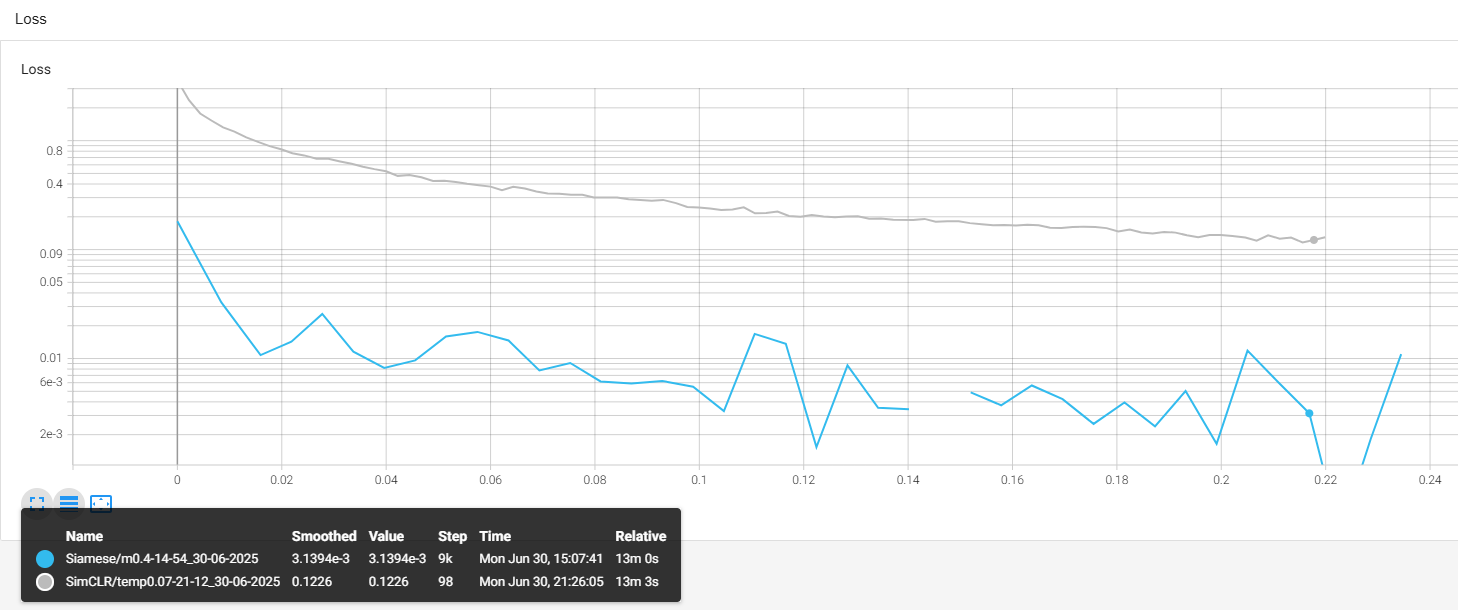

The Siamese model has clearly trained more effectively — it reached a significantly lower loss 

The SimCLR model appears undertrained due to the short training duration (100 epochs). It may perform better with more training epochs. 

## Embedding visualization

In [121]:
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE

from sklearn.cluster import KMeans
from sklearn.metrics import adjusted_rand_score


In [115]:
def display_projections(points, labels, ax=None, legend=None):
    """ Displaying low-dimensional data projections """
    
    COLORS = ['r', 'b', 'g', 'y', 'purple', 'orange', 'k', 'brown', 'grey',
              'c', "gold", "fuchsia", "lime", "darkred", "tomato", "navy"]
    
    legend = [f"Class {l}" for l in np.unique(labels)] if legend is None else legend
    if(ax is None):
        _, ax = plt.subplots(1,1,figsize=(12,6))
    for i,l in enumerate(np.unique(labels)):
        idx = np.where(l==labels)

        ax.scatter(points[idx, 0], points[idx, 1], label=legend[i], c=COLORS[i])
    ax.legend(loc="best")

In [116]:
from collections import Counter
import numpy as np

labels = np.array([sample[1] for sample in lfw_dataset])
top10_labels = [label for label, _ in Counter(labels).most_common(10)]
top10_labels

[1871, 1047, 5458, 1404, 1892, 373, 2175, 2941, 2468, 2682]

In [117]:
class FilteredLFW(torch.utils.data.Dataset):
    def __init__(self, base_dataset, allowed_labels):
        self.base = base_dataset
        self.allowed = set(allowed_labels)
        self.indices = [i for i, (_, label) in enumerate(base_dataset) if label in self.allowed]
        self.classes = [base_dataset.classes[i] for i in allowed_labels]

    def __len__(self):
        return len(self.indices)

    def __getitem__(self, idx):
        real_idx = self.indices[idx]
        return self.base[real_idx]
        
filtered_dataset = FilteredLFW(lfw_dataset, top10_labels)

filtered_loader = torch.utils.data.DataLoader(
    filtered_dataset,
    batch_size=BATCH_SIZE,
    shuffle=False
)

In [118]:
best_model_name = "Siamese_m0.4_iter10000.0"

best_model = SiameseModel()
load_model(best_model, best_model_name)
best_model.to(device)

imgs_flat = []
embs = []
labels = []
best_model = best_model.eval()
with torch.no_grad():
    for img, lbl in tqdm(filtered_loader):
        imgs = img.to(device)
        emb = best_model.backbone(imgs)
        
        labels.append(lbl)
        embs.append(emb.cpu())
        imgs_flat.append(img.cpu().flatten(1))

labels = np.concatenate(labels)
embs = np.concatenate(embs)
imgs_flat = np.concatenate(imgs_flat)

/home/user/imashevv1/CudaLabSS25/venv/lib/python3.8/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/user/imashevv1/CudaLabSS25/venv/lib/python3.8/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 12/12 [00:00<00:00, 12.41it/s]


/tmp/ipykernel_3831227/3767938697.py:2: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use('seaborn')


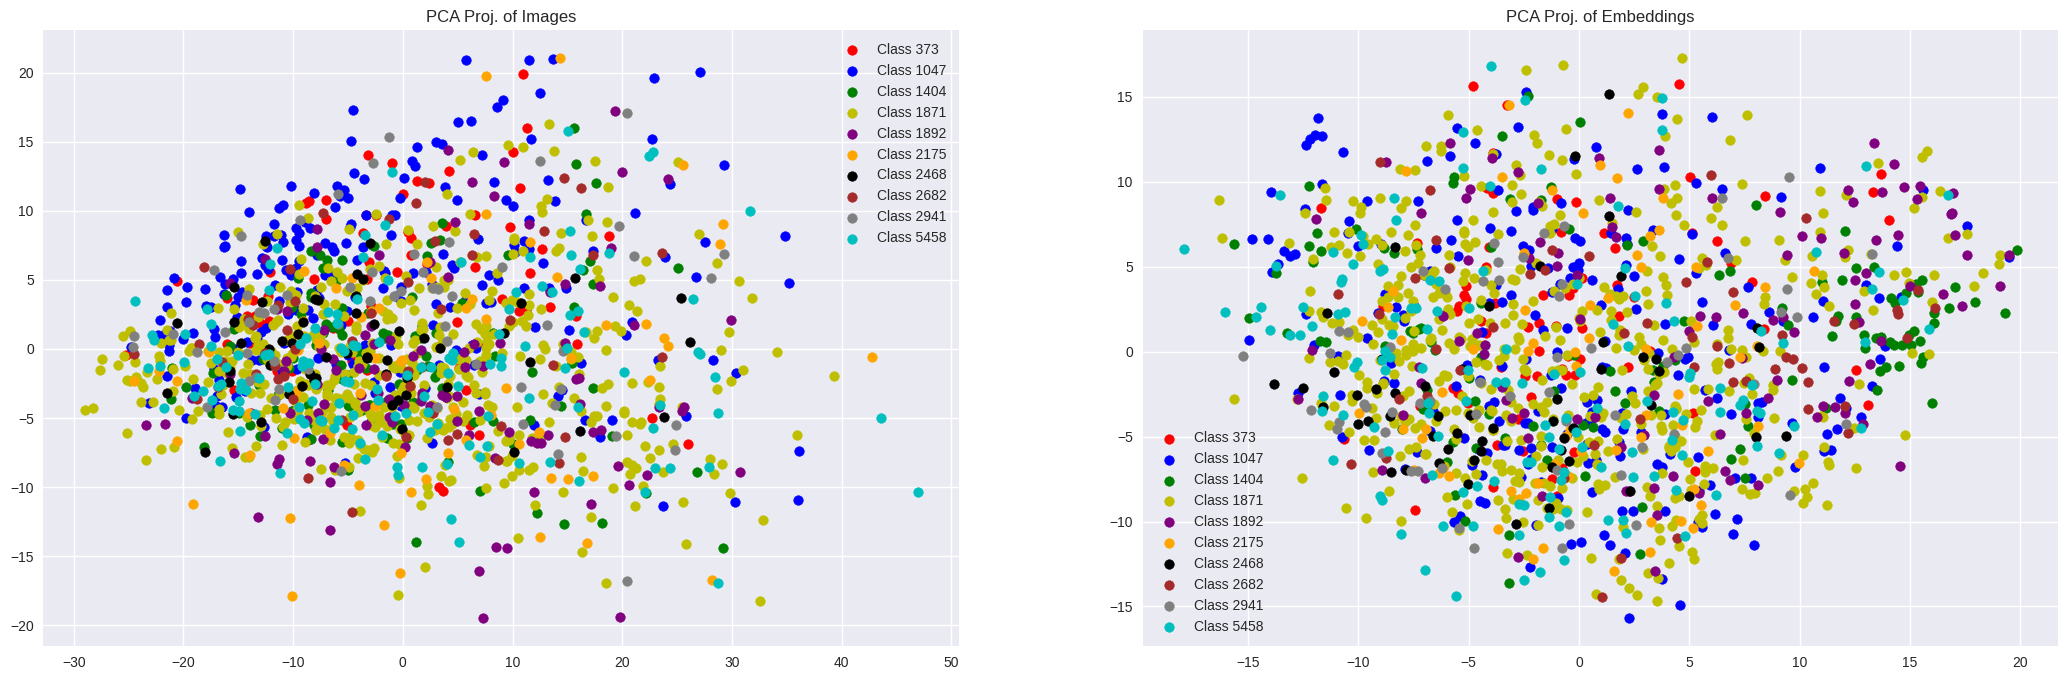

In [119]:
N = 5000
plt.style.use('seaborn')
fig,ax = plt.subplots(1,2,figsize=(26,8))
display_projections(pca_imgs[:N], labels[:N], ax=ax[0])
ax[0].set_title("PCA Proj. of Images")
display_projections(pca_embs[:N], labels[:N], ax=ax[1])
ax[1].set_title("PCA Proj. of Embeddings")
plt.show()

### SimCLR model

In [122]:
best_model_name = "SimCLR_t0.07_iter100"

best_model = SimCLR()
load_model(best_model, best_model_name)
best_model.to(device)

imgs_flat = []
embs = []
labels = []
best_model = best_model.eval()
with torch.no_grad():
    for img, lbl in tqdm(filtered_loader):
        imgs = img.to(device)
        emb = best_model.backbone(imgs)
        
        labels.append(lbl)
        embs.append(emb.cpu())
        imgs_flat.append(img.cpu().flatten(1))

labels = np.concatenate(labels)
embs = np.concatenate(embs)
imgs_flat = np.concatenate(imgs_flat)

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 12/12 [00:00<00:00, 12.45it/s]


In [123]:
pca_imgs = PCA(n_components=2).fit_transform(imgs_flat)
pca_embs = PCA(n_components=2).fit_transform(embs)

/tmp/ipykernel_3831227/3767938697.py:2: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use('seaborn')


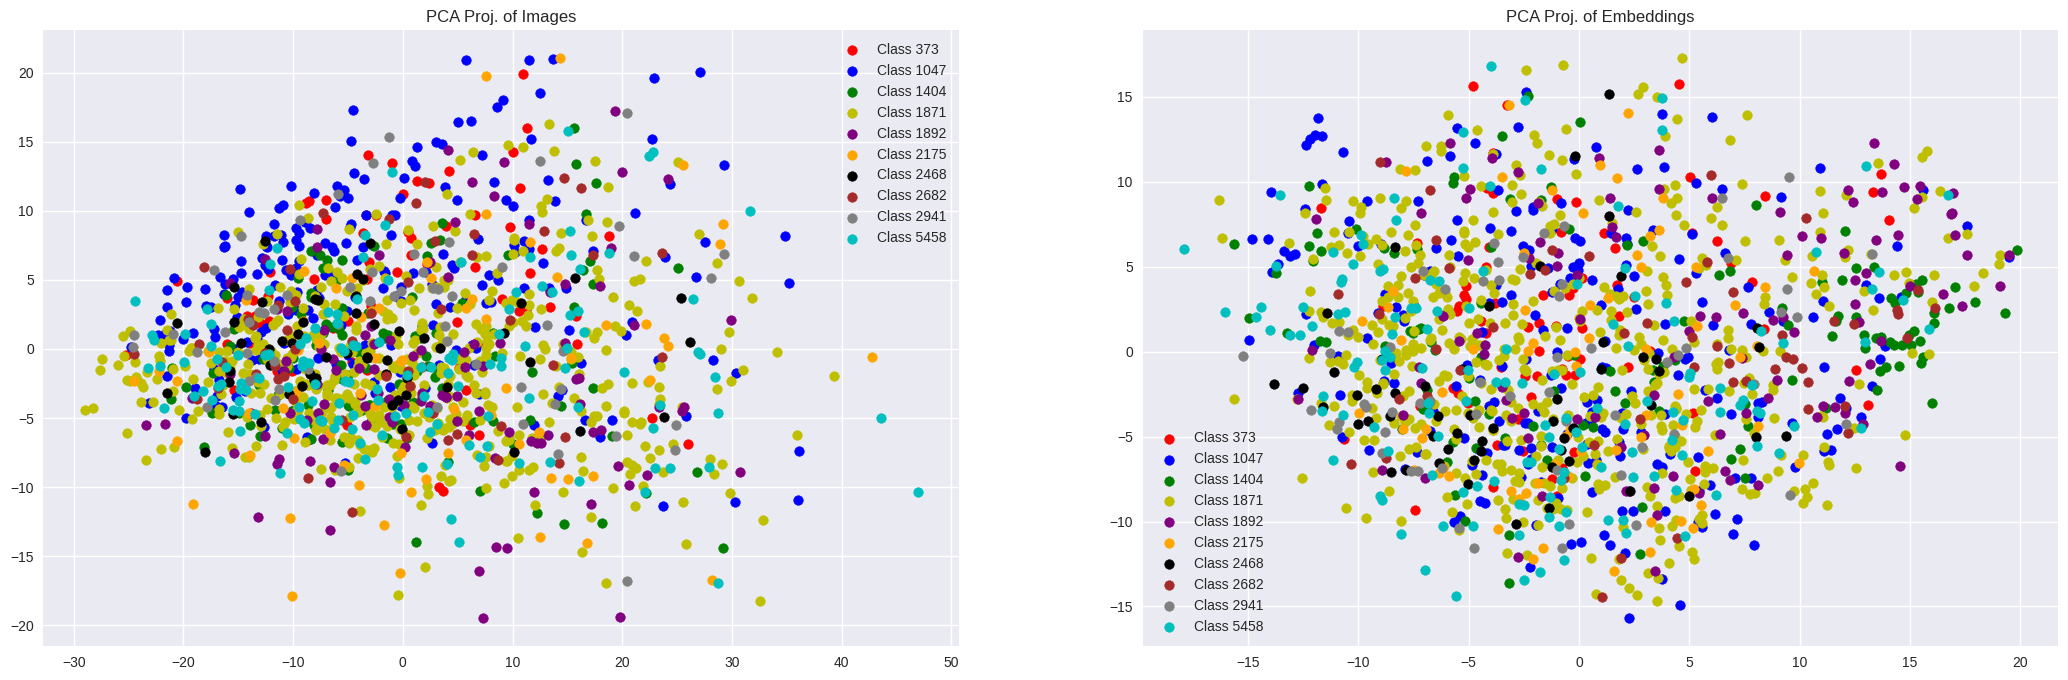

In [124]:
N = 5000
plt.style.use('seaborn')
fig,ax = plt.subplots(1,2,figsize=(26,8))
display_projections(pca_imgs[:N], labels[:N], ax=ax[0])
ax[0].set_title("PCA Proj. of Images")
display_projections(pca_embs[:N], labels[:N], ax=ax[1])
ax[1].set_title("PCA Proj. of Embeddings")
plt.show()

## Extra

In [89]:
best_model_name = "Siamese_m0.4_iter10000.0"

best_model = SiameseModel()
load_model(best_model, best_model_name)
best_model.to(device)

SiameseModel(
  (backbone): ResNetBackbone(
    (feature_extractor): Sequential(
      (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=True)
      (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
      (4): Sequential(
        (0): BasicBlock(
          (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (relu): ReLU(inplace=True)
          (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        )
        (1): BasicBlock(
          (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn1): Ba

In [90]:
from PIL import Image

transform = transforms.Compose([
    transforms.Resize((64, 64)),
    transforms.ToTensor()
])

img_path = "data/selfies/vlad.jpg"
image = Image.open(img_path).convert('RGB')
image_vlad = transform(image).unsqueeze(0).to(device)  # shape: (1, 3, 64, 64)

img_path = "data/selfies/veronika.jpg"
image = Image.open(img_path).convert('RGB')
image_veronika = transform(image).unsqueeze(0).to(device)  # shape: (1, 3, 64, 64)

best_model.eval()

with torch.no_grad():
    embedding_vlad = best_model.backbone(image_vlad) 
    embedding_veronika = best_model.backbone(image_veronika) 

In [91]:
import torch.nn.functional as F

similarity = F.cosine_similarity(embedding_vlad, embedding_veronika)
print("Cosine similarity:", similarity.item())

Cosine similarity: 0.4477996826171875


The Siamesemodel produces a cosine similarity of 0.448, which indicates that it considers the two input images to represent different people — and this is indeed correct.

In [92]:
best_model_name = "SimCLR_t0.07_iter100"

best_model = SimCLR()
load_model(best_model, best_model_name)
best_model.to(device)

best_model.eval()

with torch.no_grad():
    embedding_vlad = best_model.backbone(image_vlad) 
    embedding_veronika = best_model.backbone(image_veronika) 

similarity = F.cosine_similarity(embedding_vlad, embedding_veronika)
print("Cosine similarity:", similarity.item())

Cosine similarity: 0.8146551847457886


SimCLR thinks that these are two pictures of (probably) the same person -- wrong.

Now we try to compare two pictures of the same person:

In [125]:
best_model_name = "Siamese_m0.4_iter10000.0"

best_model = SiameseModel()
load_model(best_model, best_model_name)
best_model.to(device)

img_path = "data/selfies/vlad.jpg"
image = Image.open(img_path).convert('RGB')
image_vlad = transform(image).unsqueeze(0).to(device)  # shape: (1, 3, 64, 64)

img_path = "data/selfies/vlad2.jpg"
image = Image.open(img_path).convert('RGB')
image_vlad_another = transform(image).unsqueeze(0).to(device)  # shape: (1, 3, 64, 64)

best_model.eval()

with torch.no_grad():
    embedding_vlad = best_model.backbone(image_vlad) 
    embedding_veronika = best_model.backbone(image_vlad_another) 

similarity = F.cosine_similarity(embedding_vlad, embedding_veronika)
print("Cosine similarity:", similarity.item())

Cosine similarity: 0.8329035043716431


/home/user/imashevv1/CudaLabSS25/venv/lib/python3.8/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/user/imashevv1/CudaLabSS25/venv/lib/python3.8/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


The model correctly recognized that both images show the same person